In [1]:
from tqdm import tqdm

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import src.util as util
import scipy
import copy
import statsmodels.api as sm
import pingouin as pg
import shap

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso, LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance

from statsmodels.formula.api import ols
from scipy import stats
from scipy.stats import ttest_ind
from statsmodels.stats.outliers_influence import variance_inflation_factor

c:\Python\Lib\site-packages\shap\utils\_clustering.py:34: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
c:\Python\Lib\site-packages\shap\utils\_clustering.py:53: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
c:\Python\Lib\site-packages\shap\utils\_clustering.py:62: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.

In [2]:
config_data = util.load_config()

## Collect Data Set

In [3]:
def load_dataset(config_data: dict) -> pd.DataFrame:
    # Load set of data
    X_train = util.pickle_load(config_data["train_set_path"][0])
    y_train = util.pickle_load(config_data["train_set_path"][1])

    X_valid = util.pickle_load(config_data["valid_set_path"][0])
    y_valid = util.pickle_load(config_data["valid_set_path"][1])

    X_test = util.pickle_load(config_data["test_set_path"][0])
    y_test = util.pickle_load(config_data["test_set_path"][1])

    # concatenate x and y each set
    train_set = pd.concat([X_train, y_train], axis = 1)
    valid_set = pd.concat([X_valid, y_valid], axis = 1)
    test_set = pd.concat([X_test, y_test], axis = 1)

    # return 3 set of data
    return train_set, valid_set, test_set

In [4]:
train_set, valid_set, test_set = load_dataset(config_data)

In [5]:
## set default pandas show
pd.set_option('display.max_columns', None)

In [6]:
train_set.shape

(42299, 39)

# **Exploratory Data Analysis (EDA)**

## **QUALITATIVE VARIABLE**

### Checking data outlier on Categoric attributes

In [7]:
## Split the value into Float and Object List
float64_list = sorted(train_set.select_dtypes('float64').columns.to_list(), key=str.lower)
object_list = sorted(train_set.select_dtypes('object').columns.to_list(), key=str.lower)

<div style="background-color: yellow;">

#### **Barplot**

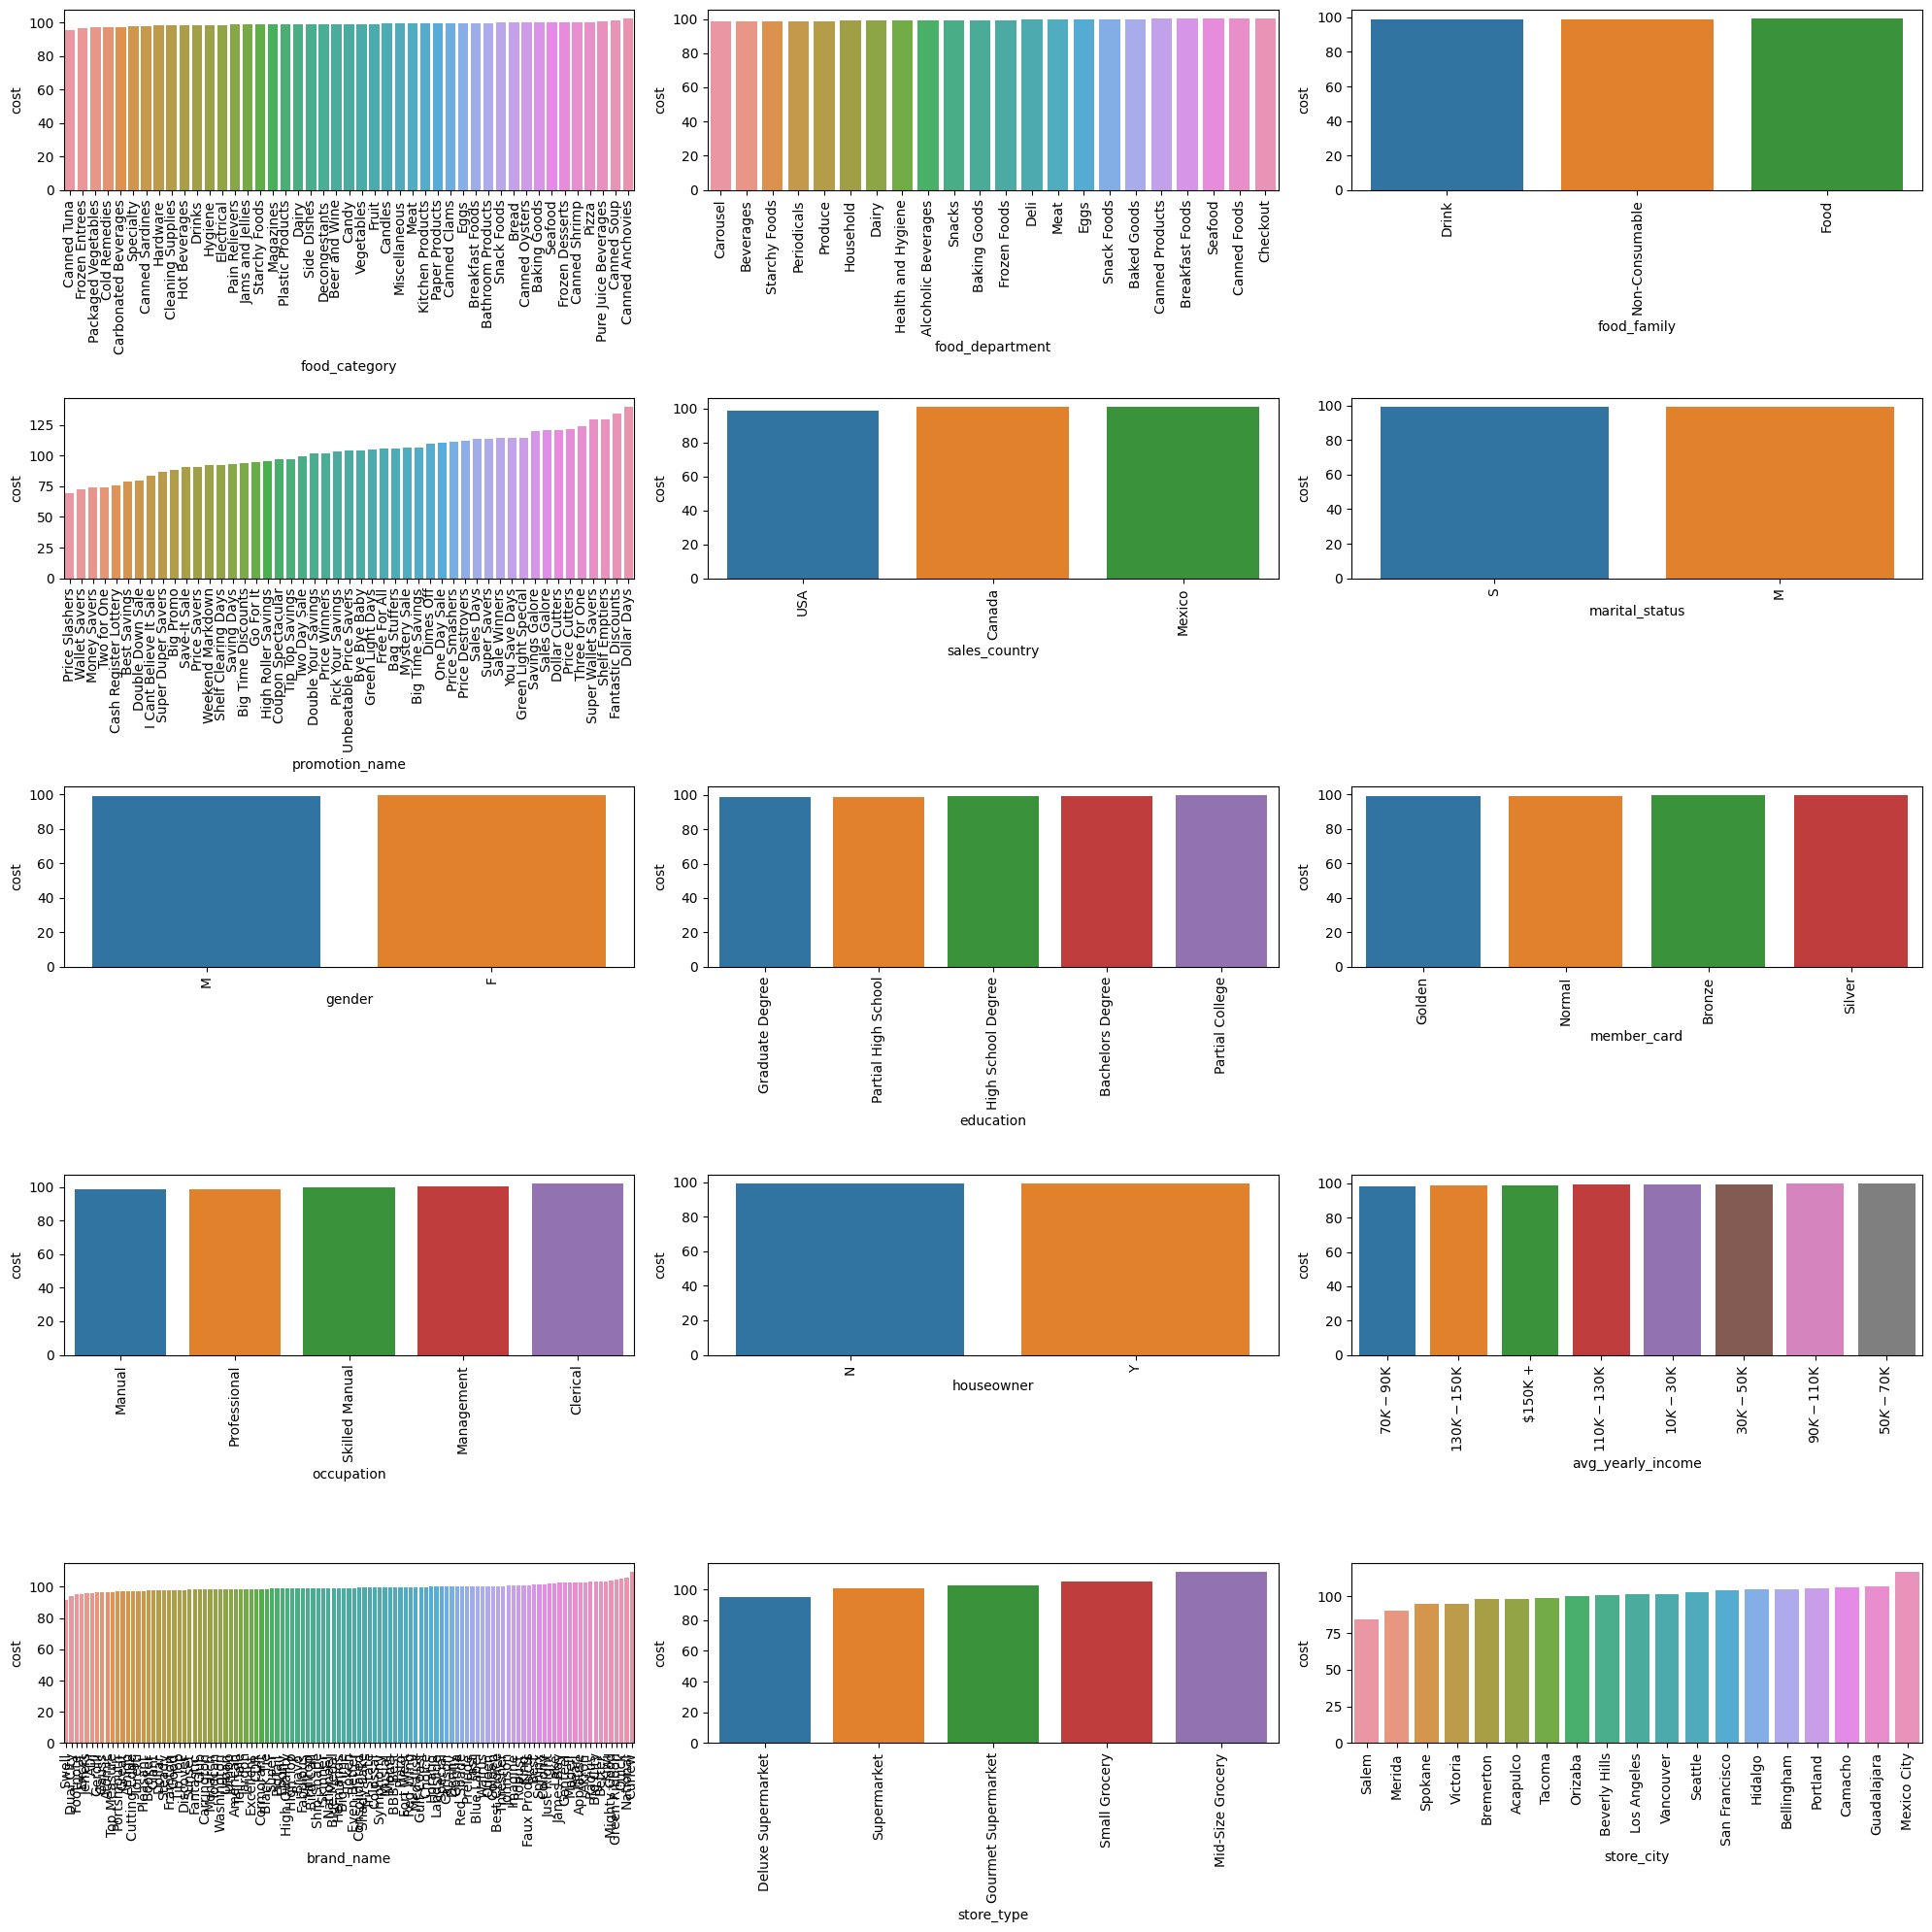

In [8]:
lst_cate_column = []
for column in train_set.columns:
    if (train_set[column].dtype == 'O'):
        lst_cate_column.append(column)
#----------------------------------------------------------------
rows = 5
columns = 3
count = 0

fig, axs = plt.subplots(rows, columns, figsize=(20,20))

for i in range(rows):
    for j in range(columns):
        ## if number of nrow, ncol outspace the list of data it will stop
        if count >= len(lst_cate_column):
            break 
        
        ## Barplot
        sns.barplot(ax=axs[i, j], data=train_set.groupby(lst_cate_column[count]
                                                   )['cost'].mean().sort_values().to_frame().reset_index()
                    , x=lst_cate_column[count], y='cost')
        
        # Change xlabel position
        axs[i, j].tick_params(axis='x', rotation=90)
        count += 1
        
fig.tight_layout()  # Adjust the spacing between subplots manually
plt.show()

<div style="background-color: yellow;">

#### **Pointplot**

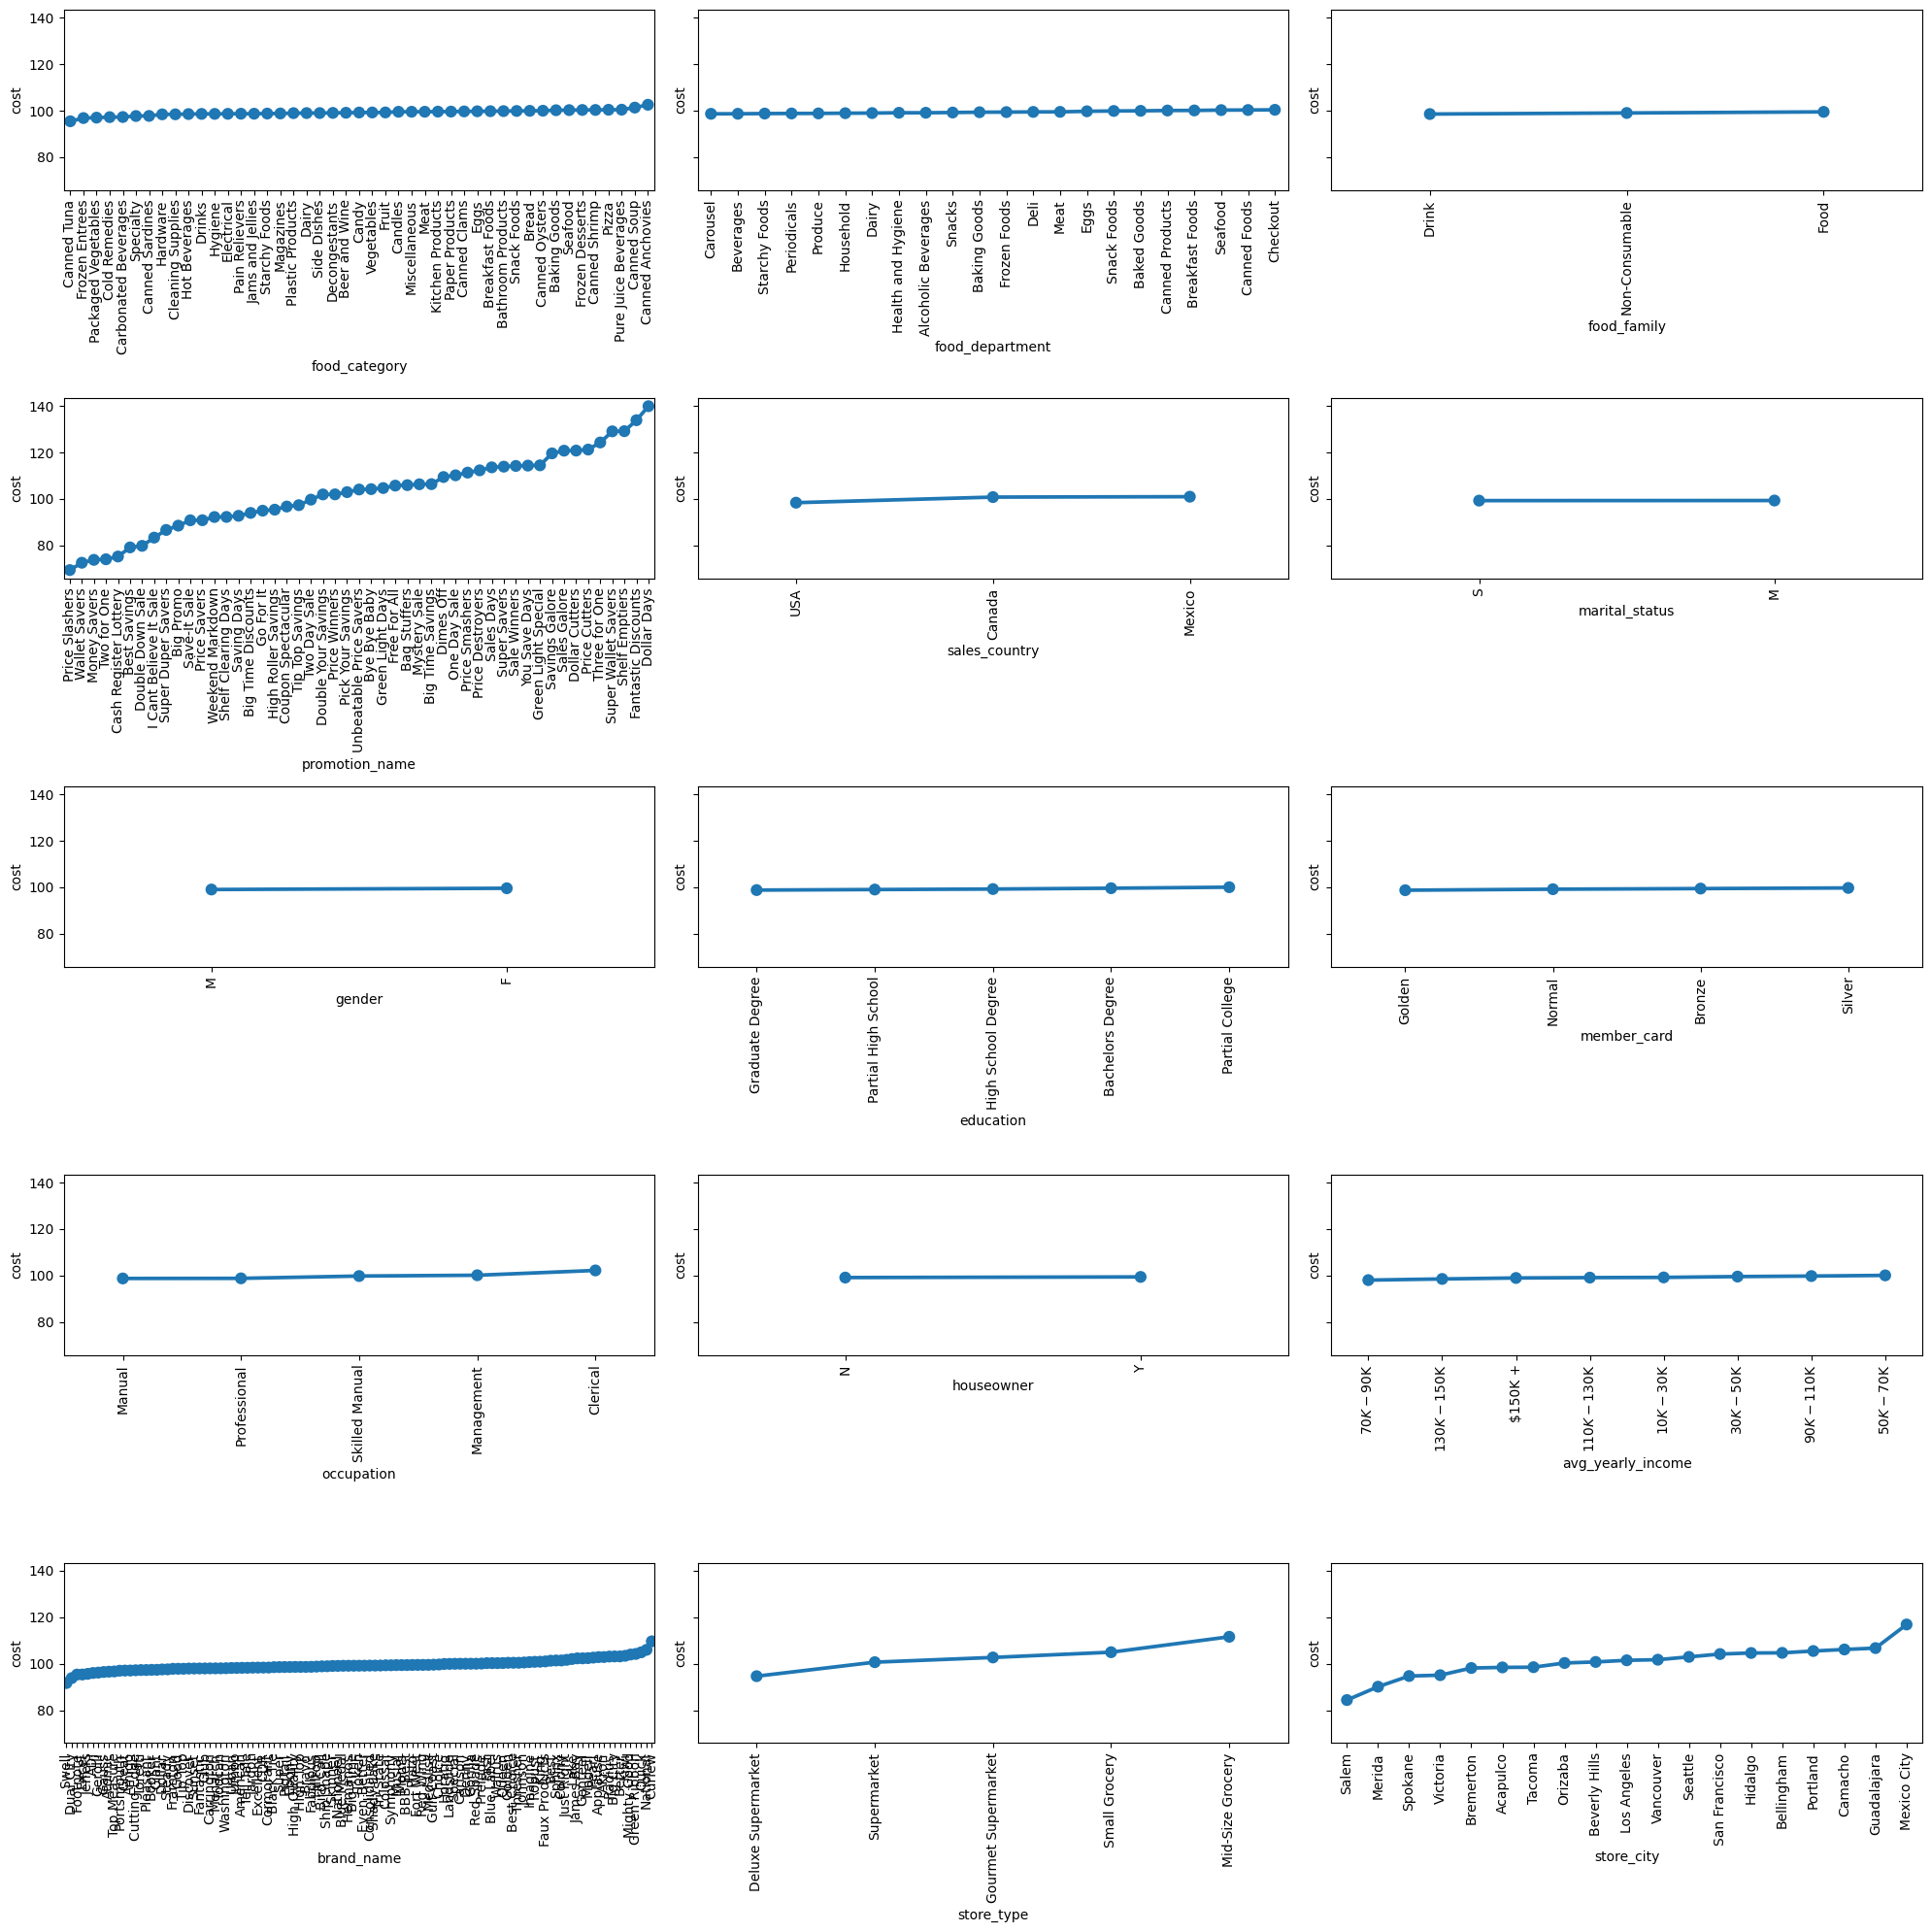

In [9]:
lst_cate_column = []
for column in train_set.columns:
    if (train_set[column].dtype == 'O'):
        lst_cate_column.append(column)
#----------------------------------------------------------------
rows = 5
columns = 3
count = 0

fig, axs = plt.subplots(rows, columns, figsize=(20,20), sharey=True)
for i in range(rows):
    for j in range(columns):
        ## if number of nrow, ncol outspace the list of data it will stop
        if count >= len(lst_cate_column):
            break 
        
        ## Barplot
        sns.pointplot(ax=axs[i, j], data=train_set.groupby(lst_cate_column[count]
                                                   )['cost'].mean().sort_values().to_frame().reset_index()
                    , x=lst_cate_column[count], y='cost')
        
        # Change xlabel position
        axs[i, j].tick_params(axis='x', rotation=90)
        count += 1
        
fig.tight_layout()  # Adjust the spacing between subplots manually
plt.show()

### Statistical Inference    
    
    According to barplot and pointplot between category feature vs label (cost)
    There're few barplots that represent no significant different mean between feature toward cost, hence we can drop these features from the data.
**food_category, food_department, food_familiy, sales_country, education, member_card, occupation, avg_yearly_income**

    However, do these pointplot can represent the same treatment for population?
    ANOVA test is used in order to understand is there a difference in the population between different groups of independent variables (features) with respect to dependent variables (label)
    Simply, we test for the equivalency of multiple population means.

![Variable-Selection](\pics\categoric-selection.webp "Variable-Selection")


### <span style="background-color: yellow;">**ONE-WAY ANOVA**</span>

F test for differences in more than two means: <br>
>**H₀:** μ₁= μ₂ = μ₃ = … = μ𝒸 <br>
>**H₁:** Not all μᵢ’s are equal, where i = 1, 2, 3, …, c. <br>
Level of significance = α <br>

    A one-way ANOVA has the below given null and alternative hypotheses:

    H0 (null hypothesis): μ1 = μ2 = μ3 = … = μk (It implies that the means of all the population are equal)
    H1 (null hypothesis): It states that there will be at least one population mean that differs from the rest

**Reference:** <br>
[anova-python-ols](https://www.pythonfordatascience.org/anova-python/)<br>
[anova-python-scratch](https://towardsdatascience.com/anova-test-with-python-cfbf4013328b)

In [10]:
## ONE-WAY ANOVA TEST
## Using statmodels

lst_cate_column = []
for column in train_set.columns:
    if (train_set[column].dtype == 'O'):
        lst_cate_column.append(column)
        
lst_cate_column.append('cost')
#----------------------------------------------------------------
model_anova = {}

for i,col in enumerate(lst_cate_column):
    model = ols(f'cost ~ C({col})', data=train_set[lst_cate_column]).fit()
    aov_table = sm.stats.anova_lm(model, typ=2)
    
    model_anova[col] = aov_table['PR(>F)']
    
model_anova_ = (pd.DataFrame(
    data=model_anova.copy(),
    columns=lst_cate_column,
)
                .melt(var_name='columns', value_name='PR(>F)')
                .sort_values(by=['columns'])
                .drop_duplicates()
                .dropna()
)

model_anova_['PR(>F)'] = model_anova_['PR(>F)'].apply(lambda x: round(x,4))

In [11]:
model_anova_

,columns,PR(>F)
209,avg_yearly_income,0.0147
229,brand_name,0.6212
325,cost,0.0000
136,education,0.2843
4,food_category,0.8708
24,food_department,0.9619
44,food_family,0.1148
121,gender,0.0657
198,houseowner,0.3448
104,marital_status,0.9013


    Check PR(>F) is larger then .05
    H₀: μ₁= μ₂ = μ₃ = … = μ𝒸
>If PR(>F) > .05 : **Failed to Reject H0**, that states no significant different mean between independent groups

In [12]:
model_anova_[model_anova_['PR(>F)'] > 0.05]['columns'].values.tolist()

['brand_name',
 'education',
 'food_category',
 'food_department',
 'food_family',
 'gender',
 'houseowner',
 'marital_status',
 'member_card']

These features has shown in pointplot no different means and testes using ANOVA also, <br>
So we can drop these features on our model <br>
<br>
In order to tell which groups differed significantly, post-hoc tests need to be conducted. Before one goes through that work, the assumptions should be checked first in case any modifications need to be made to the model.

**Reference:**<br>
[Parametric-Assumption](https://www.pythonfordatascience.org/parametric-assumptions-python/)<br>
[Probability-Plot](https://online.stat.psu.edu/stat501/lesson/4/4.6) <br>
[PPCC Interpretation](https://www.itl.nist.gov/div898/handbook/eda/section3/ppccplot.htm)<br>
[Crit-Value-PPCC](https://www.itl.nist.gov/div898/handbook/eda/section3/eda3676.htm)

#### **PARAMETRIC ASSUMPTION**<br>

>1. Independence
>2. Normality, Population distributions are Gaussian
>3. Samples have equal variances

**Rerefence:**
[Parametric Assumption](https://www.pythonfordatascience.org/parametric-assumptions-python/)

##### **NORMALITY**
>using `Shapiro-Wilk Test` and `Probability Plot`<br>
<br>
The Shapiro-Wilk <br>
**null hypothesis**: the data was drawn from a normal distribution.

Shapiro-Wilk Test:
ShapiroResult(statistic=0.9927749037742615, pvalue=5.637760033610177e-40)
However the N > 5000, using probability plot


p-value may not be accurate for N > 5000.


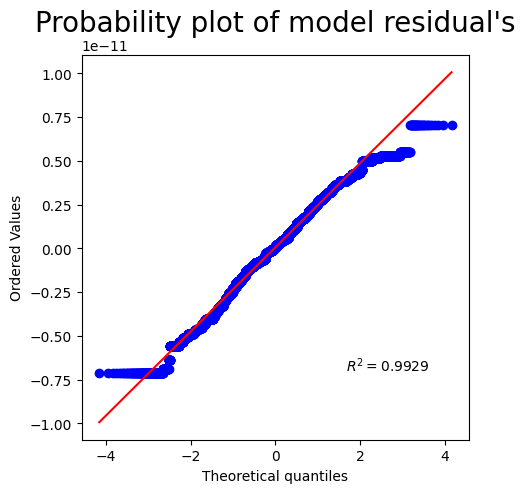

In [13]:
## NORMALITY using Shapiro-Wilk Test and Probability Plot
## The Shapiro-Wilk test tests the null hypothesis: the data was drawn from a normal distribution.

print(f"Shapiro-Wilk Test:")
print('\033[1m'+f"{stats.shapiro(model.resid)}")
print("="*50)
print('\033[0m'+"However the N > 5000, using probability plot")

fig = plt.figure(figsize= (5, 5))
ax = fig.add_subplot(111)

normality_plot, stat = stats.probplot(model.resid, plot= plt, rvalue= True)
ax.set_title("Probability plot of model residual's", fontsize= 20)
ax.set

plt.show()

    PPCC shown as R2, if R2 is nearly 1 it shown distribution is uniform

##### **HOMOGENITY OF VARIANCE**
    In this test, we assume the data has *equal variance*.
    However, perform ANOVA on *inequal variance* could harm the result.
    To identify does independent variable groups does have equal variance, we used **Barlett's Test** or **Levene's Test** if data has departures from normality and power (Conover, 1981).

If assumption violated we can used another non-parametric statistical test such as 
>**Welch's ANOVA**, **Kruskal-Wallis H**

it may be worthwhile to check this assumption visually as well (Boxplot). <br>

**Reference:**<br>
[Welch's Anova](https://www.geeksforgeeks.org/how-to-perform-welchs-anova-in-python/)

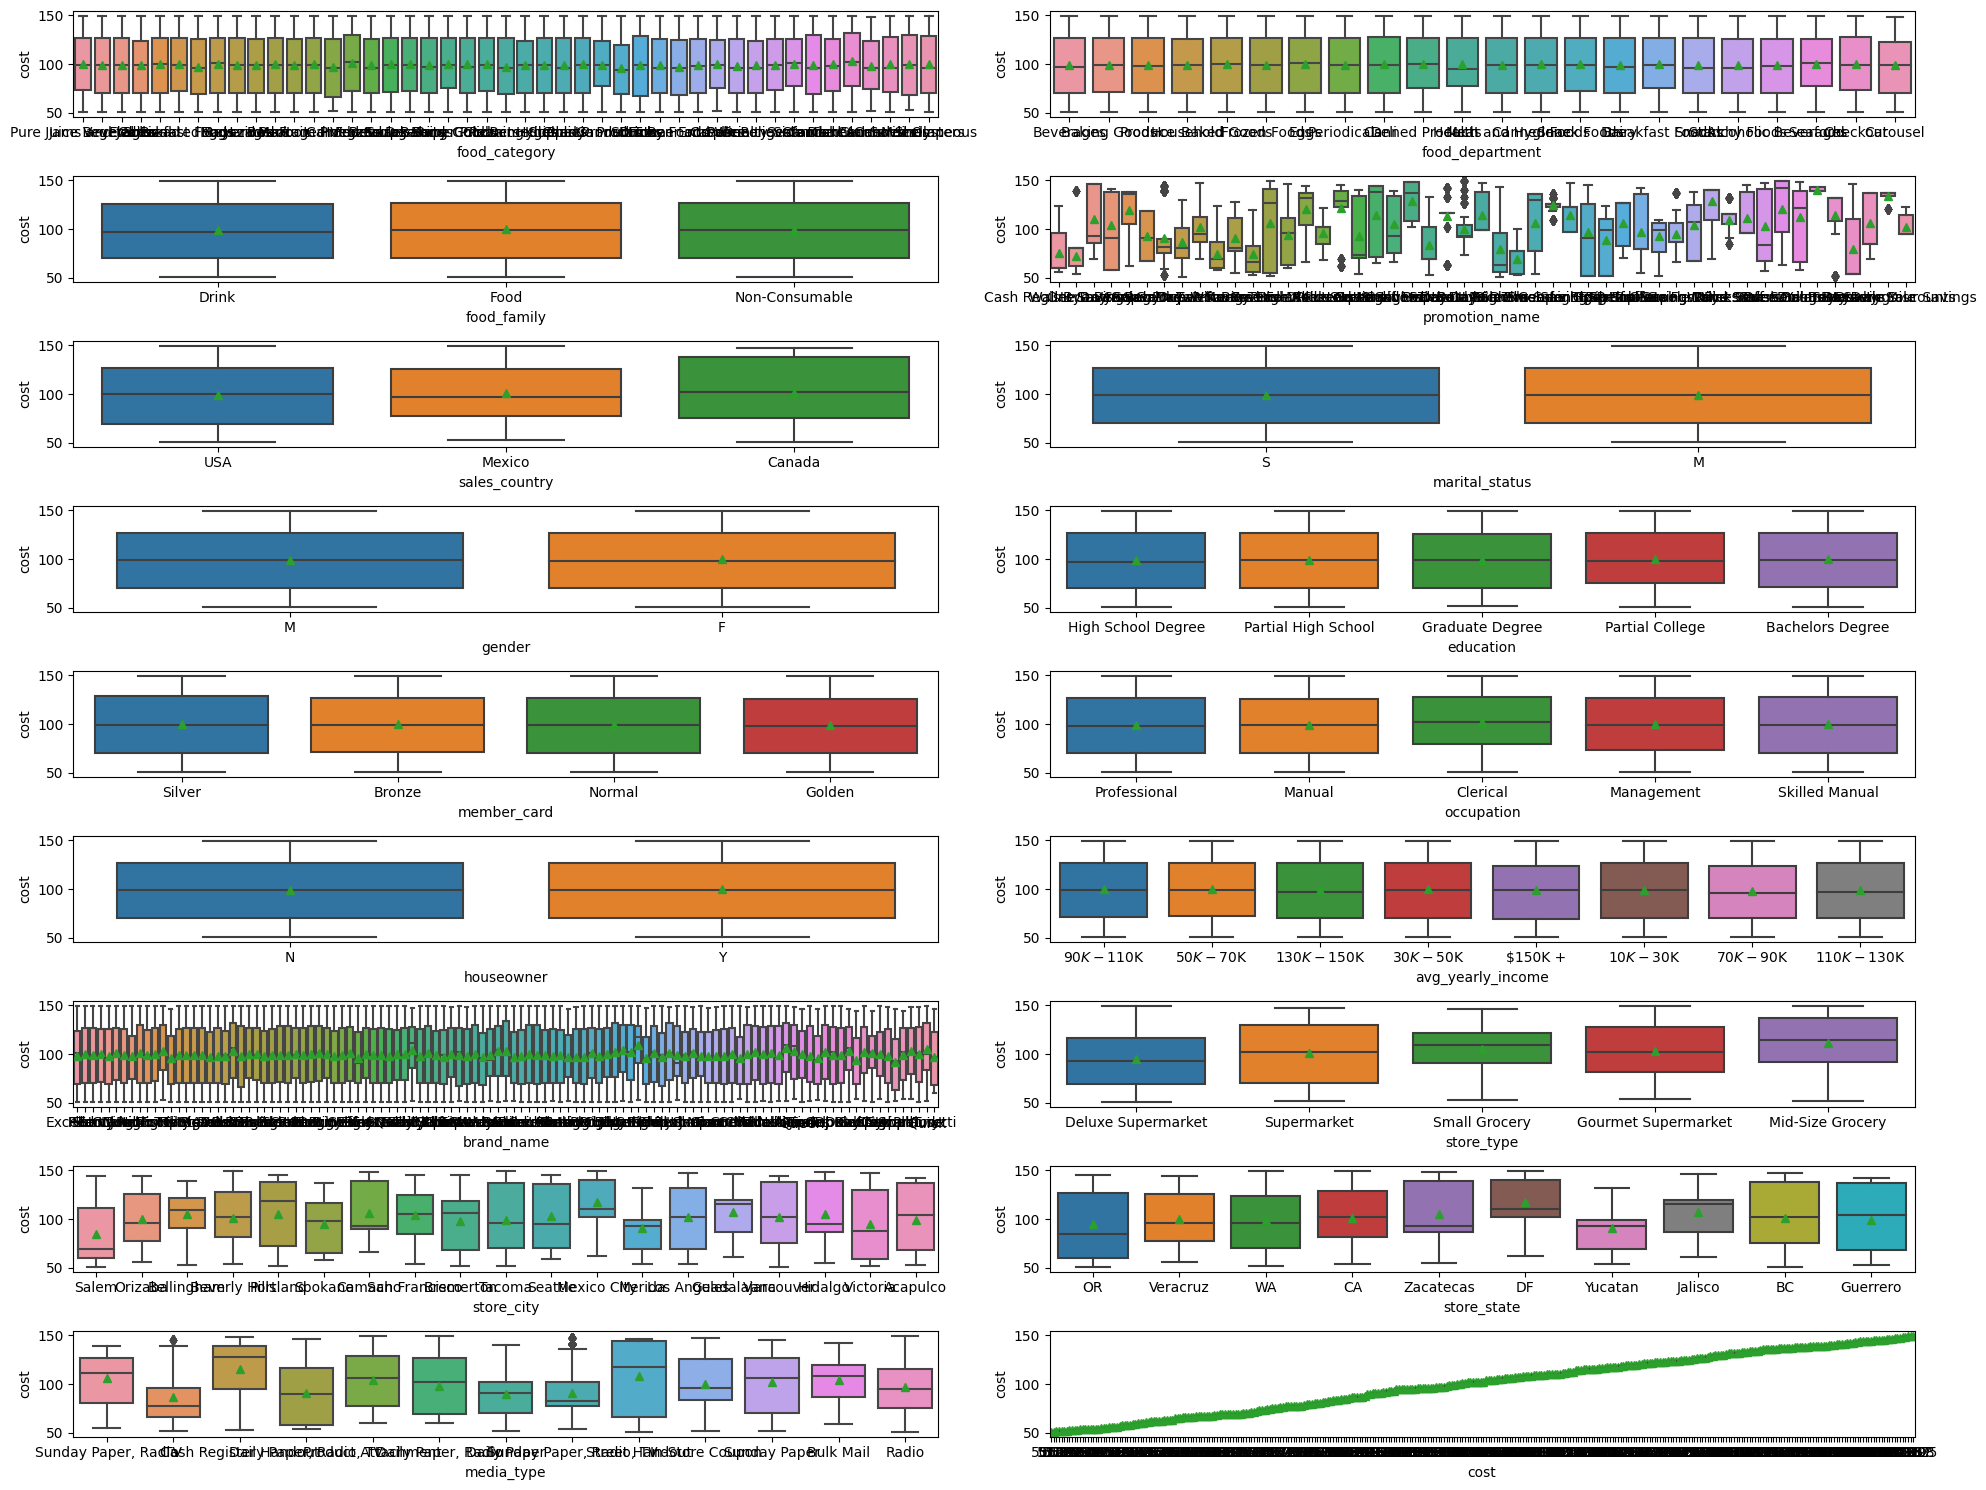

In [15]:
## HOMOGENITY OF VARIANCE
fig, axes = plt.subplots(nrows=9, ncols=2, figsize=(20,15))
axes = axes.ravel()
cols = lst_cate_column

for col, ax in zip(cols,axes):
    sns.boxplot(data=train_set, y='cost', x=col, ax=ax,
                showmeans=True)

    
fig.tight_layout()
plt.show()

### **TWO-GROUP COMPARED to Quantitative Output**

Check the parametric assumption of equal variance on variable<br>
> **Levene's Test**

If Parametric --> **T-Test** <br>
If Non-Parametric --> **Welch's Test**

**Reference:**<br>
[Levene's Test](https://www.pythonfordatascience.org/parametric-assumptions-python/)<br>
[Levene Params on Python](https://www.statology.org/levenes-test-python/)

In [16]:
# Define list column two independent group
lst_cate_bool = ['marital_status','gender','houseowner','recyclable_package',
                 'low_fat','coffee_bar','video_store','salad_bar','prepared_food',
                 'florist']
#----------------------------------------------------------------

## Change the output of two-group into 0 or 1
train_set.marital_status = train_set.marital_status.map(dict(S=0.0, M=1.0))
train_set.gender = train_set.gender.map(dict(F=0.0, M=1.0))
train_set.houseowner = train_set.houseowner.map(dict(N=0.0, Y=1.0))

#------------------------------------------------------------------
# Levene's Test

for col in lst_cate_bool:
    levene = stats.levene(train_set['cost'][train_set[col]==1],
                                        train_set['cost'][train_set[col]==0])
    print('levene ' + '\033[1m' + f'{col}' + '\033[0m'+ f': {levene}')
 

levene marital_status: LeveneResult(statistic=0.34138308811262486, pvalue=0.5590350792841461)
levene gender: LeveneResult(statistic=0.740265911515631, pvalue=0.38958058725529066)
levene houseowner: LeveneResult(statistic=3.2592825784464243, pvalue=0.07102729946524858)
levene recyclable_package: LeveneResult(statistic=0.3776735243656835, pvalue=0.5388542697672365)
levene low_fat: LeveneResult(statistic=0.049286021119461516, pvalue=0.8243114115746145)
levene coffee_bar: LeveneResult(statistic=17.512701250408977, pvalue=2.8597044211906147e-05)
levene video_store: LeveneResult(statistic=77.33016171984504, pvalue=1.499736475438524e-18)
levene salad_bar: LeveneResult(statistic=38.12805598678165, pvalue=6.685179219386503e-10)
levene prepared_food: LeveneResult(statistic=38.12805598678165, pvalue=6.685179219386503e-10)
levene florist: LeveneResult(statistic=6.660825911585594, pvalue=0.0098588590037186)


    The Levene test tests the null hypothesis that all input samples are from populations with equal variances.
    The test is not significant (huge p-value), meaning that there is homogeneity of variances and we can proceed.
    
However, some does have non-equal variance with *pvalue < .05* such as:<br>
**coffee_bar, video_store, salad_bar, prepared_food, florist**


In [17]:
# Equal Variance
lst_cate_bool_eq = ['marital_status','gender','houseowner','recyclable_package',
                 'low_fat']

# Non-Equal Variance
lst_cate_bool_in = ['coffee_bar','video_store','salad_bar','prepared_food',
                 'florist']

        since the data seem to be similar and very hard to tell just by visualization
        Equal Variance would perform Independence T-Test.
        Non-Equal Variance would perform Welch's Test.

-------------------------
        H0 : There's difference mean between var1 and var2,
        H1 : There's no difference mean between var1 and var2,
>**H₀: μ₁= μ₂** <br>
>**H₁: μ₁<> μ₂**
<br>

        Independence T-test used Two-sided alternative with equal_var = True,
        while Welch's Test used Two-sided alternative with equal_var = False

**Reference:**<br>
[Independence T-Test](https://www.pythonfordatascience.org/independent-samples-t-test-python/)<br>
[Welch's Test](https://pythonfordatascienceorg.wordpress.com/welch-t-test-python-pandas/)        

<div style="background-color: yellow;">

#### **EQUAL VARIANCE INDEPENDENCE T-TEST**

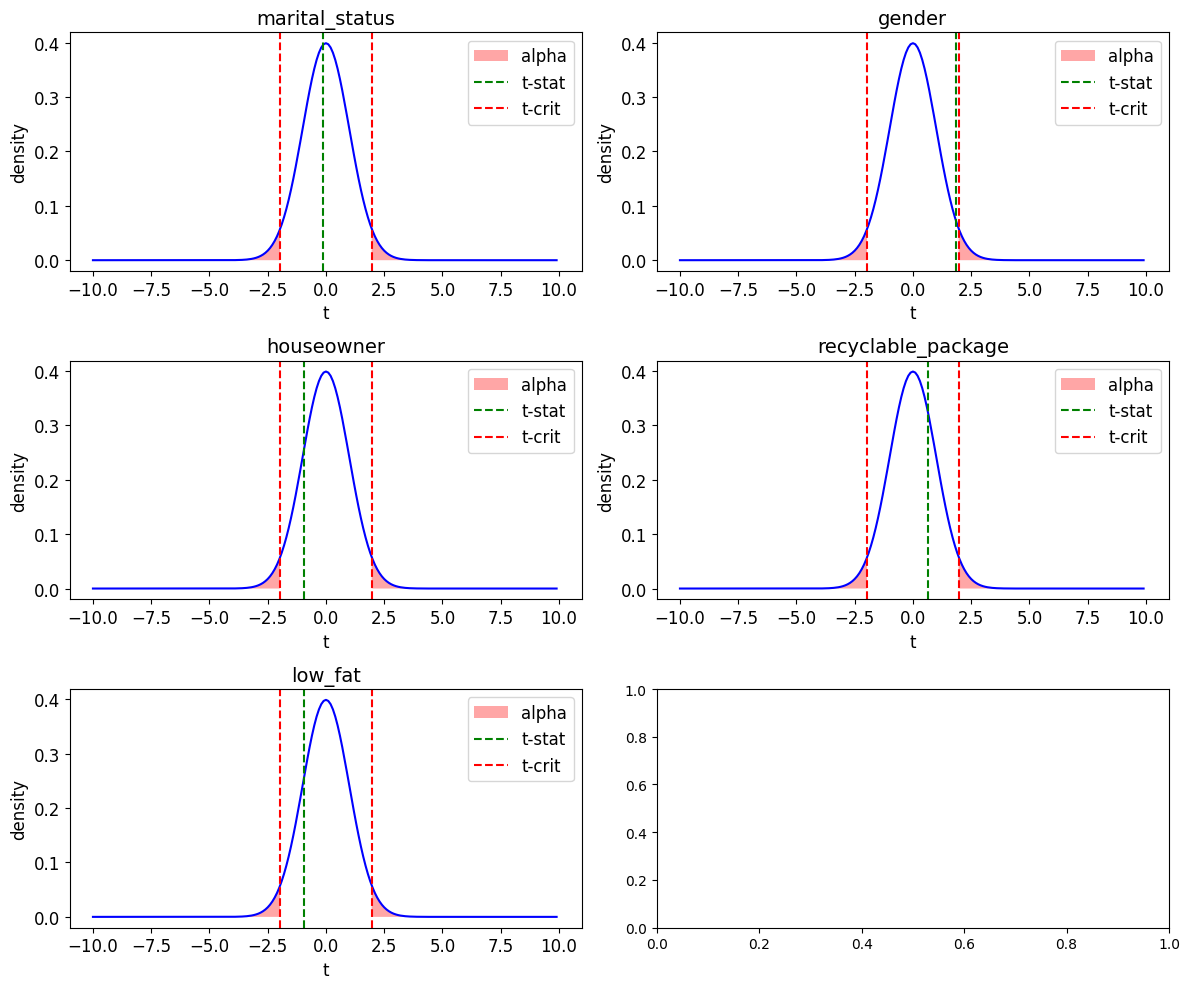

In [18]:
import matplotlib.pyplot as plt

alpha = 0.05
fig, axes = plt.subplots(3, 2, figsize=(12, 10))  # Create subplots with 3 rows and 2 columns

for i, ax in zip(lst_cate_bool_eq, axes.flatten()):
    
    lst_0 = train_set.cost[train_set[i] == 0]
    lst_1 = train_set.cost[train_set[i] == 1]
    
    degree = lst_0.count() + lst_1.count()
    
    t_stat, p_value = ttest_ind(lst_0, lst_1, equal_var=True, alternative="two-sided")
    t_crit = scipy.stats.t.ppf(alpha/2, degree)

    x = np.arange(-10,10,0.1)
    
    ax.set_title(f"{i}", fontsize=14)  # Set the subplot title
    ax.plot(x, scipy.stats.norm.pdf(x, 0, 1), color='blue')  # Plot sample
    
    # plot alpha region
    x_alpha = np.arange(-10, t_crit, 0.01)
    y_alpha = scipy.stats.norm.pdf(x_alpha)
    ax.fill_between(x=x_alpha, y1=y_alpha, facecolor='red', alpha=0.35, label='alpha')
    
    # plot alpha region
    x_alpha = np.arange(-(t_crit), 10, 0.01)
    y_alpha = scipy.stats.norm.pdf(x_alpha)
    ax.fill_between(x=x_alpha, y1=y_alpha, facecolor='red', alpha=0.35)
    
    # plot z-crit and z-stats
    ax.axvline(np.round(t_stat, 4), color="green", linestyle="--", label="t-stat")
    ax.axvline(t_crit, color="red", linestyle="--", label="t-crit")
    ax.axvline(-(t_crit), color="red", linestyle="--")
    
    ax.legend(loc='best', fontsize=12)
    ax.set_xlabel("t", fontsize=12)
    ax.set_ylabel("density", fontsize=12)
    ax.tick_params(axis='both', labelsize=12)

plt.tight_layout()  # Adjust the spacing between subplots
plt.show()

<div style="background-color: yellow;">

#### **NON-EQUAL VARIANCE WELCH'S TEST**

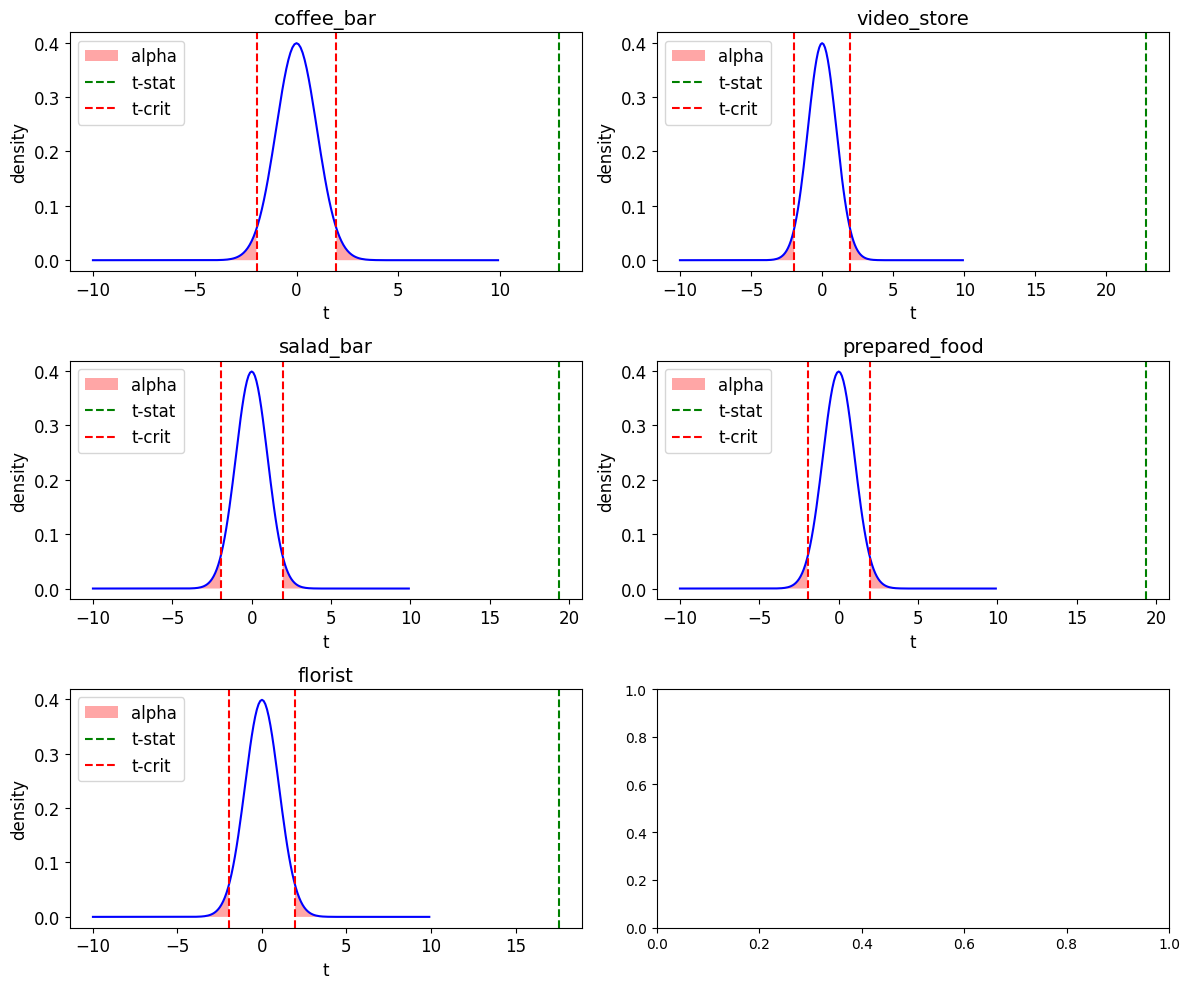

In [19]:
import matplotlib.pyplot as plt

alpha = 0.05
fig, axes = plt.subplots(3, 2, figsize=(12, 10))  # Create subplots with 3 rows and 2 columns

for i, ax in zip(lst_cate_bool_in, axes.flatten()):
    
    lst_0 = train_set.cost[train_set[i] == 0]
    lst_1 = train_set.cost[train_set[i] == 1]
    
    degree = lst_0.count() + lst_1.count()

    x = np.arange(-10,10,0.1)
    
    t_stat, p_value = ttest_ind(lst_0, lst_1, equal_var=False)
    t_crit = scipy.stats.t.ppf(alpha/2, degree)
    
    ax.set_title(f"{i}", fontsize=14)  # Set the subplot title
    ax.plot(x, scipy.stats.norm.pdf(x, 0, 1), color='blue')  # Plot sample
    
    # plot alpha region
    x_alpha = np.arange(-10, t_crit, 0.01)
    y_alpha = scipy.stats.norm.pdf(x_alpha)
    ax.fill_between(x=x_alpha, y1=y_alpha, facecolor='red', alpha=0.35, label='alpha')
    
    # plot alpha region
    x_alpha = np.arange(-(t_crit), 10, 0.01)
    y_alpha = scipy.stats.norm.pdf(x_alpha)
    ax.fill_between(x=x_alpha, y1=y_alpha, facecolor='red', alpha=0.35)
    
    # plot z-crit and z-stats
    ax.axvline(np.round(t_stat, 4), color="green", linestyle="--", label="t-stat")
    ax.axvline(t_crit, color="red", linestyle="--", label="t-crit")
    ax.axvline(-(t_crit), color="red", linestyle="--")
    
    ax.legend(loc='best', fontsize=12)
    ax.set_xlabel("t", fontsize=12)
    ax.set_ylabel("density", fontsize=12)
    ax.tick_params(axis='both', labelsize=12)

plt.tight_layout()  # Adjust the spacing between subplots
plt.show()

marital_status
Failed to Reject H0, p-value marital_status > alpha: 0.90 > 0.05
-------------------------------------------------------
Failed to Reject H0, t-stat marital_status > t-crit then : -0.12 > -1.96


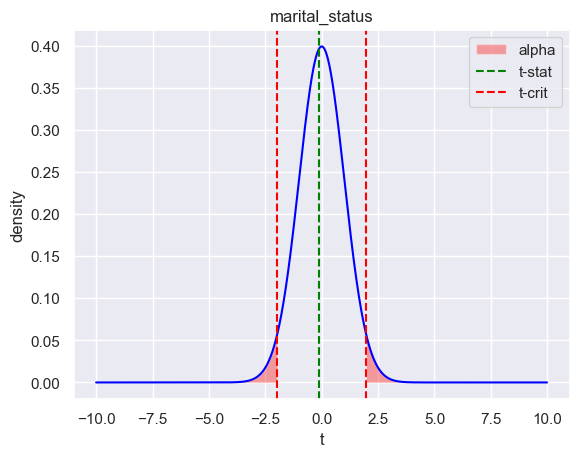

gender
Failed to Reject H0, p-value gender > alpha: 0.07 > 0.05
-------------------------------------------------------
Failed to Reject H0, t-stat gender > t-crit then : 1.84 > -1.96


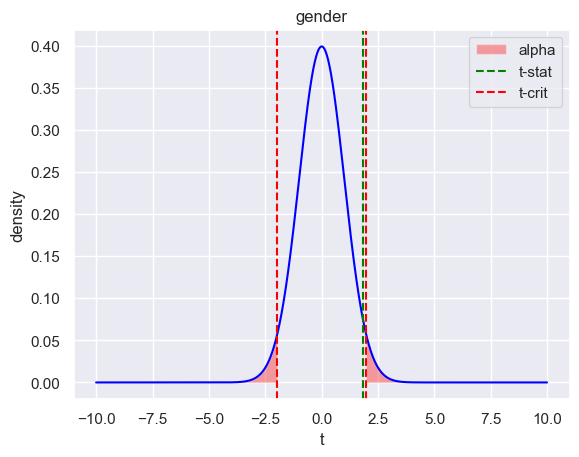

houseowner
Failed to Reject H0, p-value houseowner > alpha: 0.34 > 0.05
-------------------------------------------------------
Failed to Reject H0, t-stat houseowner > t-crit then : -0.95 > -1.96


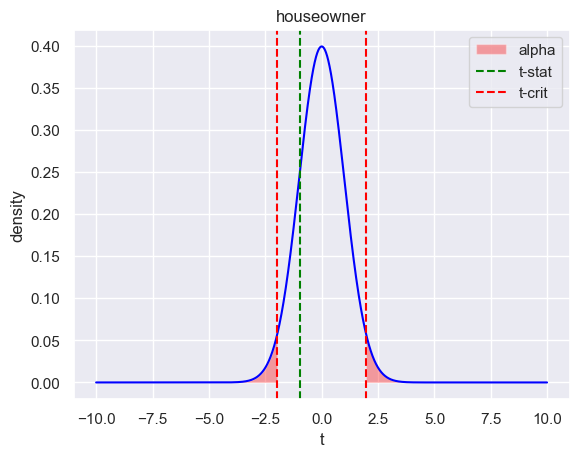

recyclable_package
Failed to Reject H0, p-value recyclable_package > alpha: 0.53 > 0.05
-------------------------------------------------------
Failed to Reject H0, t-stat recyclable_package > t-crit then : 0.63 > -1.96


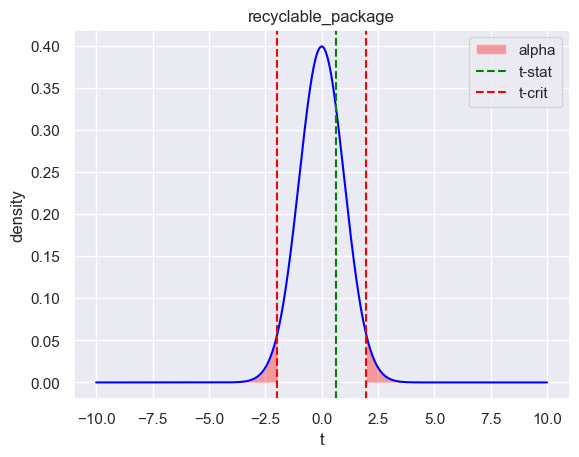

low_fat
Failed to Reject H0, p-value low_fat > alpha: 0.34 > 0.05
-------------------------------------------------------
Failed to Reject H0, t-stat low_fat > t-crit then : -0.96 > -1.96


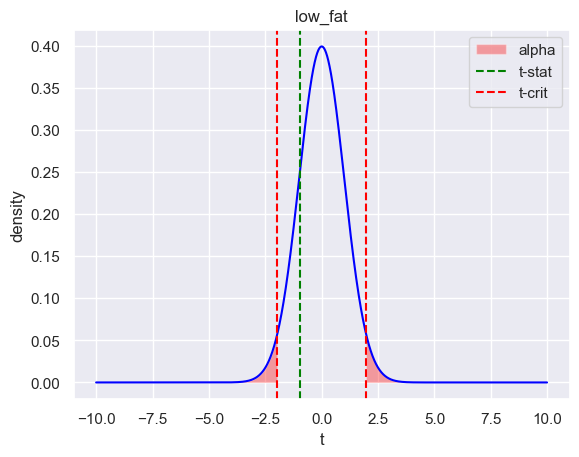

coffee_bar
Reject H0, p-value coffee_bar < alpha : 0.00 < 0.05
-------------------------------------------------------
Reject H0, t-stat coffee_bar > t-crit : 12.88 > 1.96


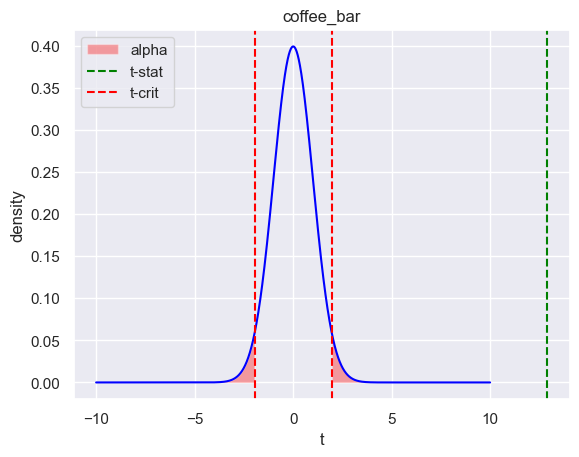

video_store
Reject H0, p-value video_store < alpha : 0.00 < 0.05
-------------------------------------------------------
Reject H0, t-stat video_store > t-crit : 22.76 > 1.96


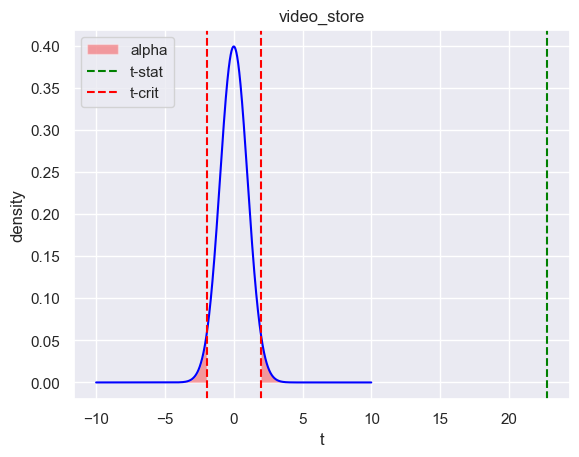

salad_bar
Reject H0, p-value salad_bar < alpha : 0.00 < 0.05
-------------------------------------------------------
Reject H0, t-stat salad_bar > t-crit : 19.34 > 1.96


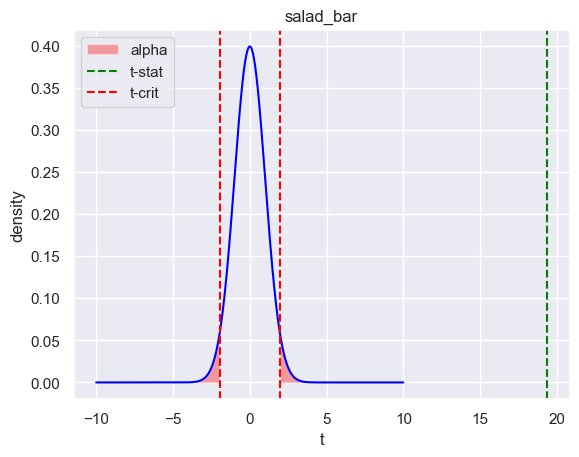

prepared_food
Reject H0, p-value prepared_food < alpha : 0.00 < 0.05
-------------------------------------------------------
Reject H0, t-stat prepared_food > t-crit : 19.34 > 1.96


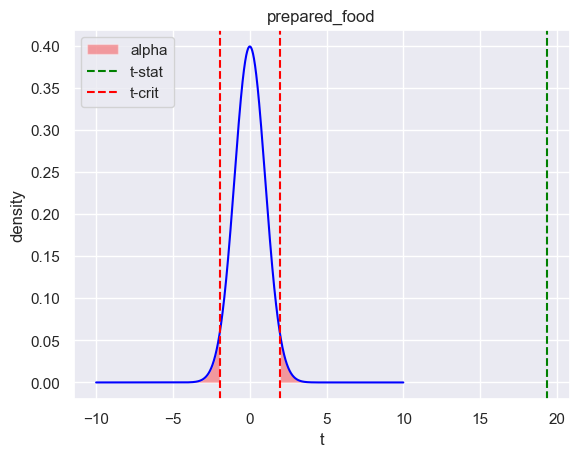

florist
Reject H0, p-value florist < alpha : 0.00 < 0.05
-------------------------------------------------------
Reject H0, t-stat florist > t-crit : 17.56 > 1.96


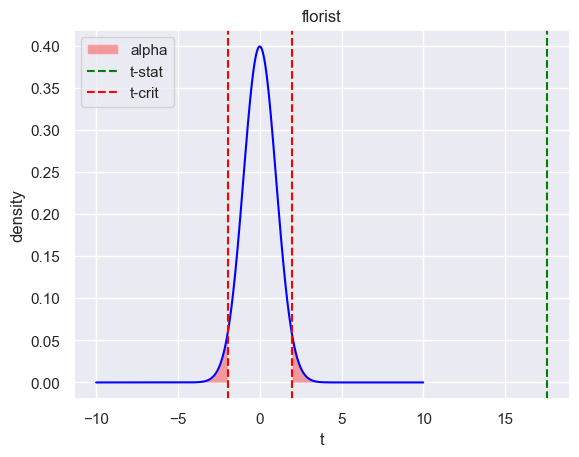

In [13]:
alpha = 0.05
for i in lst_cate_bool:
    lst_0 = train_set.cost[train_set[i] == 0]
    lst_1 = train_set.cost[train_set[i] == 1]
    # t_stat, p_value = ttest_ind(lst_0, lst_1, equal_var = False)
    
    degree = lst_0.count() + lst_1.count()
    
    t_stat, p_value = ttest_ind(lst_0, lst_1, equal_var = False, random_state = 42, alternative = "two-sided")
    t_crit = scipy.stats.t.ppf(alpha/2, degree)
    
    print(f"{i}")
    
    if(p_value <  alpha):
        print(f'Reject H0, p-value {i} < alpha : {p_value:.2f} < {alpha}')
    else:
        print(f"Failed to Reject H0, p-value {i} > alpha: {p_value:.2f} > {alpha}")
        
    print("-------------------------------------------------------")
    
   
    if(t_stat < t_crit):
        print(f'Reject H0, t-stat {i} < -t-crit : {t_stat:.2f} < {t_crit:.2f}')
    elif(t_stat > (-t_crit)):
        print(f'Reject H0, t-stat {i} > t-crit : {t_stat:.2f} > {-t_crit:.2f}')
    else:
        print(f'Failed to Reject H0, t-stat {i} > t-crit then : {t_stat:.2f} > {t_crit:.2f}')
     
    # Plot sample
    x = np.arange(-10, 10, 0.01)
    plt.plot(x, scipy.stats.norm.pdf(x, 0, 1), 
            color='blue')

    # plot alpha region
    x_alpha = np.arange(-10, t_crit, 0.01)
    y_alpha = scipy.stats.norm.pdf(x_alpha)
    plt.fill_between(x = x_alpha, 
                    y1 = y_alpha,
                    facecolor = 'red',
                    alpha = 0.35, 
                    label = 'alpha')
    
    # plot alpha region
    x_alpha = np.arange(-(t_crit), 10, 0.01)
    y_alpha = scipy.stats.norm.pdf(x_alpha)
    plt.fill_between(x = x_alpha, 
                    y1 = y_alpha,
                    facecolor = 'red',
                    alpha = 0.35)
    
    # plot z-crit and z-stats
    plt.axvline(np.round(t_stat, 4), 
                color ="green", 
                linestyle = "--", 
                label ="t-stat")
    plt.axvline(t_crit, 
                color ="red", 
                linestyle = "--", 
                label ="t-crit")
    plt.axvline(-(t_crit), 
                color ="red", 
                linestyle = "--")
    
    plt.legend(loc='best')
    plt.xlabel("t")
    plt.ylabel("density")
    plt.title(f"{i}")
    plt.show()
    


Since the statistical test information regarding Two-Group Variable test to quantitative outcome show the result <br>
<br>
All variable on **Equal Variance** is **Failed to Reject H0**, then these variable is not statistically significant since mean between group is same <br>
Besides, **Non-Equal variance** group show **Reject H0**, then these vairables is statistically significant


#### Check Two-Group Bar Plot

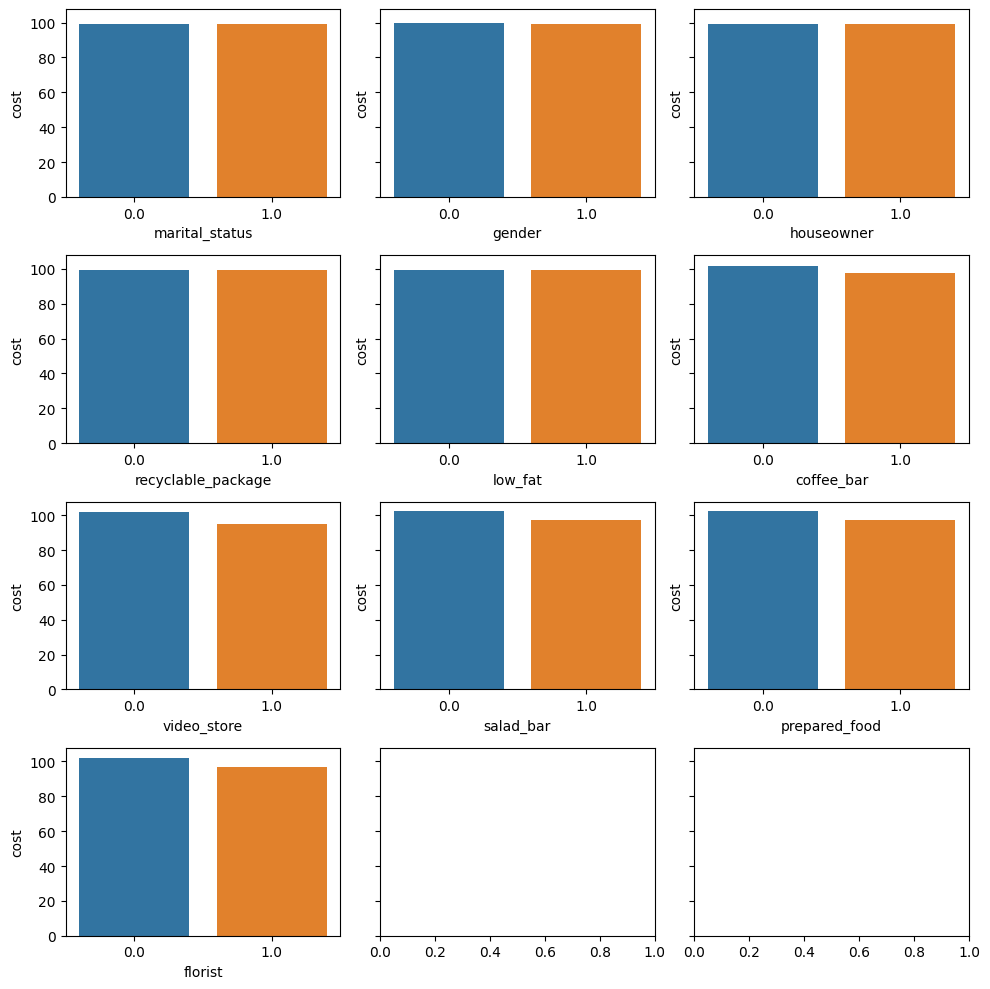

In [20]:
#----------------------------------------------------------------
rows = 4
columns = 3
count = 0

fig, axs = plt.subplots(rows, columns, figsize=(10,10), sharey=True)
# sns.set(font_scale=0.5)

for i in range(rows):
    for j in range(columns):
        ## if number of nrow, ncol outspace the list of data it will stop
        if count >= len(lst_cate_bool):
            break 
        
        ## Barplot
        sns.barplot(ax=axs[i, j], data=train_set.groupby(lst_cate_bool[count]
                                                   )['cost'].mean().sort_values().to_frame().reset_index()
                    , x=lst_cate_bool[count], y='cost')
        
        # Change xlabel position
        # axs[i, j].tick_params(axis='x', rotation=90)
        count += 1
        
fig.tight_layout()  # Adjust the spacing between subplots manually
plt.show()

### **RESULT**
    Based on ANOVA Test on More Two-Group variable test show these features is not statistically significant
> **brand_name, education, food_category, food_department, food_family, gender, houseowner, marital_status, member_card**

    On T-Test of Two-Group variable test show these features is not statistically significant also
> **marital_status, gender, houseowner, recyclable_package, low_fat**

Hence we can drop these features on our model

In [21]:
## Categorical feature that we want to drop after statistical inference...
train_set_cat = copy.deepcopy(train_set).drop(columns=[
    'brand_name','education','food_category','food_department',
    'food_family','gender','houseowner','marital_status','member_card',
    'recyclable_package', 'low_fat'
    ], axis=1)

In [22]:
train_set_cat.shape

(42299, 28)

## **QUANTITATTIVE VARIABLE**

>**Pearson Correlation** <br>
**Spearman Correlation** *if it has Ordinal Value*<br>
**Variance Inflation Factor (VIF)**<br>
**Principle Component Analysis (PCA)**<br>

Quantitative variable selection aim to drop **multicollinearity** of variable. <br>
    `Multicollinearity occurs when two or more independent variables(also known as predictor) are highly correlated with one another in a regression model` <br>
<br>
This means that an independent variable can be predicted from another independent variable in a regression model.<br>
<br>
Since in a regression model our research objective is to find out how each predictor is impacting the target variable individually,

Y=a0+a1*X1+a2*X2

Here X1 and X2 are the independent variables.
But for a situation where multicollinearity exists our independent variables are highly correlated, so if we change X1 then X2 also changes and we would not be able to see their Individual effect on Y which is our research objective for a regression model.
>**“ This makes the effects of X1 on Y difficult to differentiate  from the effects of X2 on Y. ”**

Multicollinearity may not affect the accuracy of the model as much but we might lose reliability in determining the effects of individual independent features on the dependent feature in your model and that can be a problem when we want to interpret your model.

**Reference:**<br>
[Multicollinearity](https://www.analyticsvidhya.com/blog/2021/03/multicollinearity-in-data-science/)<br>
[Numerical Feature Selection](https://www.dataknowsall.com/featureselection.html)<br>
[Numeric Feature Select Python](https://medium.com/analytics-vidhya/feature-selection-techniques-2614b3b7efcd)


<div style="background-color: yellow;">

### **PEARSON CORRELATION**

<Axes: >

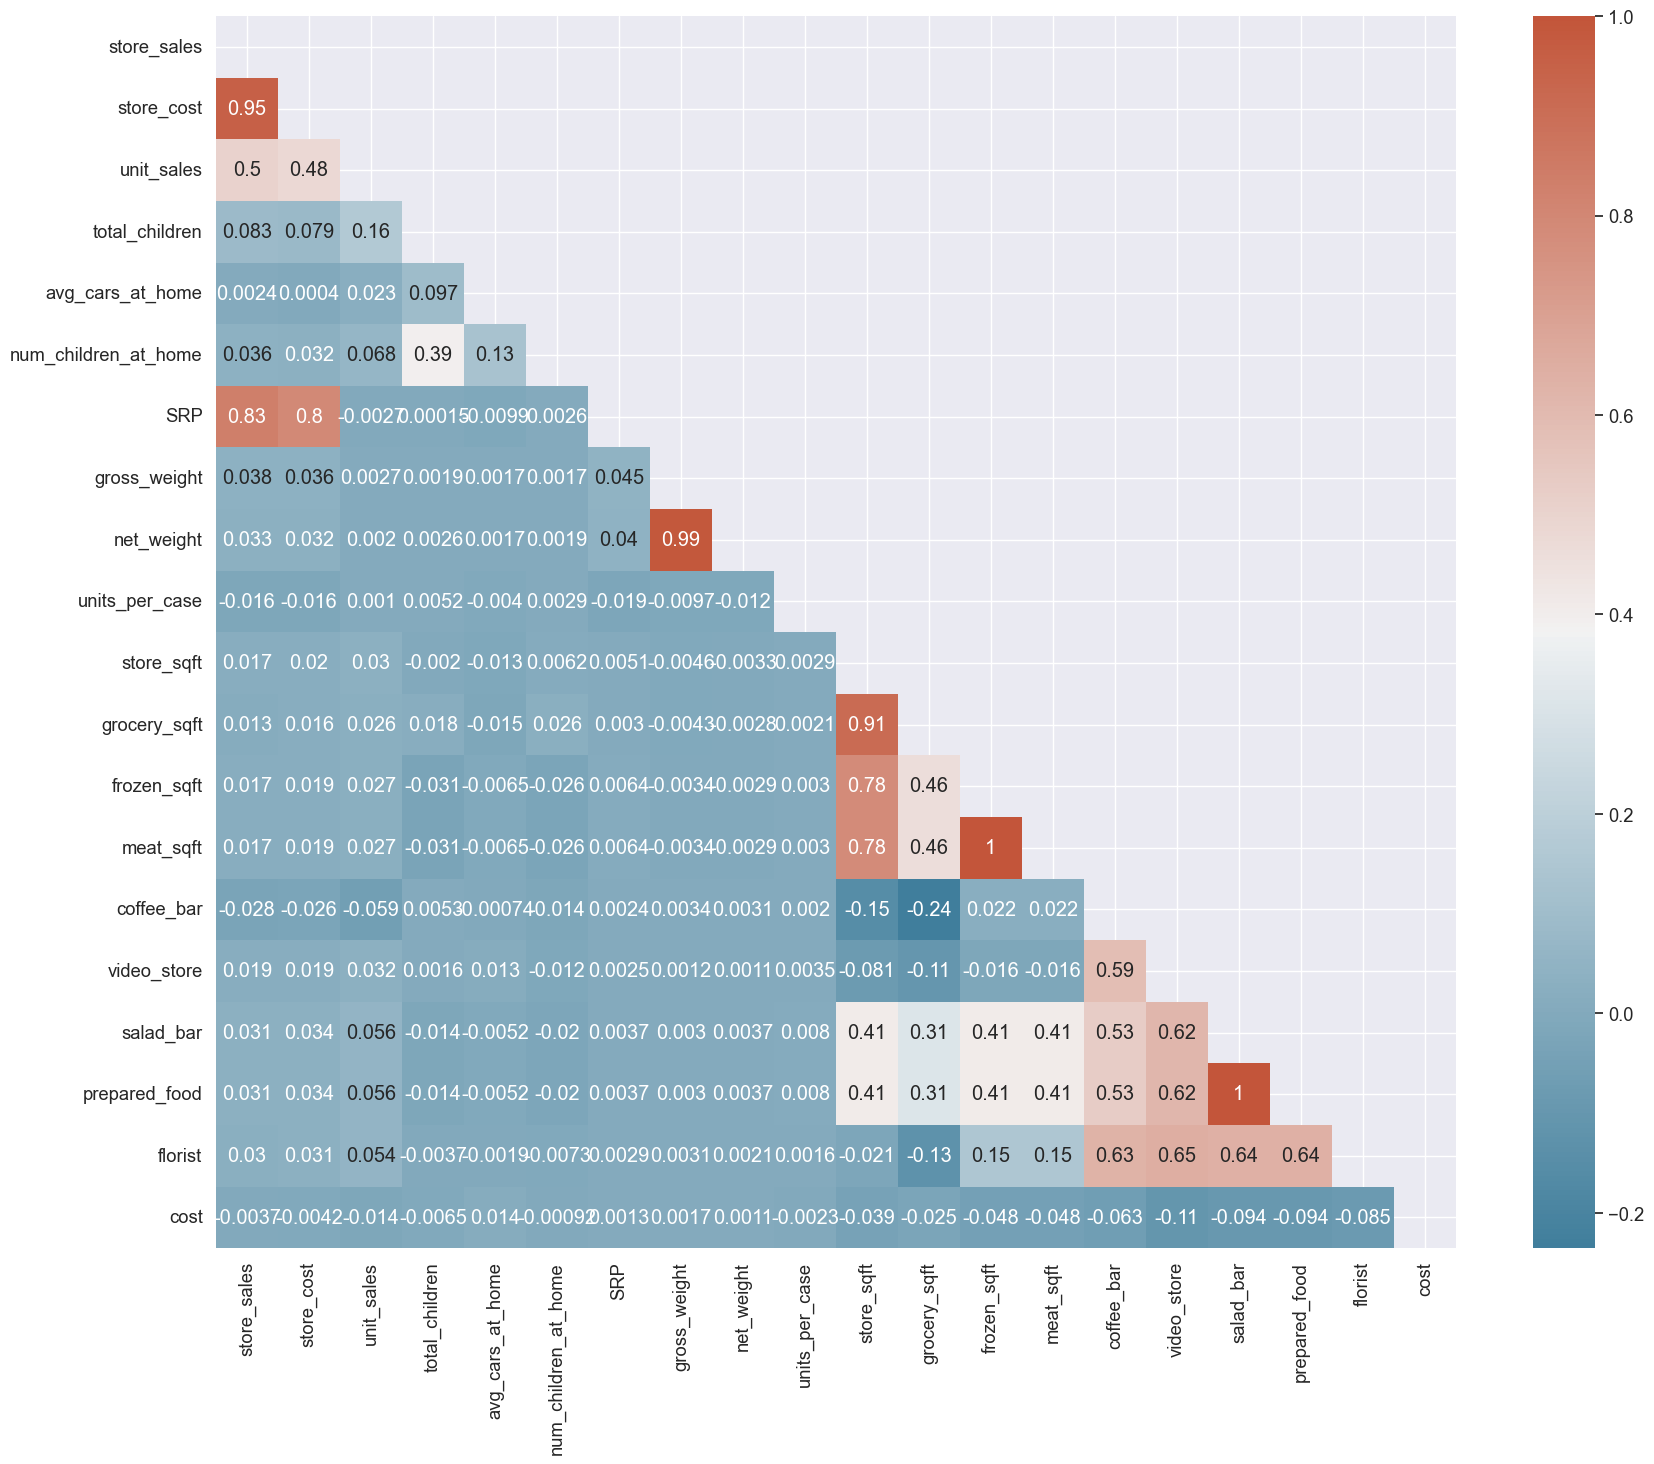

In [23]:
# Heatmap Correlation
sns.set(font_scale=1.2)

corr = train_set_cat[train_set_cat.select_dtypes('float64').columns.to_list()].corr()

fig, ax = plt.subplots(figsize=(20, 16))
mask = np.triu(np.ones_like(corr, dtype= bool))
cmap = sns.diverging_palette(230, 20, as_cmap= True)

sns.heatmap(corr, annot=True, cmap=cmap, mask=mask)

In [24]:
# Create threshold of 0.8 correlation
corr_multi = corr[corr>=0.8].reset_index()

# melted to get the features with >= 0.8 value
melted_corr = pd.melt(copy.deepcopy(corr_multi), id_vars='index', var_name='column_name', value_name='correlation').sort_values(by=['correlation']).dropna()
melted_corr.columns = ['row_name', 'column_name', 'correlation']

# Drop the features that correlated each other
melted_corr = melted_corr[melted_corr['row_name'] != melted_corr['column_name']].drop_duplicates(subset='correlation')

melted_corr

,row_name,column_name,correlation
120,store_sales,SRP,0.833045
211,grocery_sqft,store_sqft,0.912982
1,store_cost,store_sales,0.954790
148,net_weight,gross_weight,0.988925
272,frozen_sqft,meat_sqft,1.000000
356,salad_bar,prepared_food,1.000000


    To handle redundancy of between variable, we can drop variable with high correlation score of pearson correlation.

> **'store_sales', 'store_sqft', 'meat_sqft', 'salad_bar'**

<div style="background-color: yellow;">

### **VARIANCE INFLATION FACTOR (VIF)**

**Collinearity** is the state where two variables are highly correlated and contain similar information about the **variance within a given dataset.** <br>
To detect collinearity among variables, simply create a correlation matrix and find variables with large absolute values.<br>

Kutner, Nachtsheim, Neter, and Li (2004) suggest to use a VIF ≥ 10 as indication of multicollinearity

**Reference:**<br>
[Linear Regression: VIF](https://www.pythonfordatascience.org/linear-regression-python/)

In [25]:
def cal_vif(X):
    thresh = 10
    output = pd.DataFrame()
    k = X.shape[1]
    
    vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    for i in range(1,k):
        print("iteration no ", i)
        print(vif)
        a = np.argmax(vif)
        print('Max vif is for variable no: ', a)
        if(vif[a]<=thresh):
            break
        
        if(i==1):
            output = X.drop(X.columns[a], axis=1)
            vif = [variance_inflation_factor(output.values, j) for j in range(output.shape[1])]
        elif(i>1):
            output = output.drop(output.columns[a], axis=1)
            vif = [variance_inflation_factor(output.values, j) for j in range(output.shape[1])]
    
    return(output)

In [26]:

lst_num_column = []
for column in train_set_cat.columns:
    if (train_set[column].dtype == 'float64'):
        lst_num_column.append(column)

lst_num_column.remove('cost')
# --------------------------------------


X_vif = copy.deepcopy(train_set_cat)[lst_num_column]

vif_features = cal_vif(X_vif)
vif_features.head()

divide by zero encountered in scalar divide


iteration no  1
[98.89576009793223, 48.075335571227086, 43.99111229528579, 4.705732421678489, 4.9200092276533836, 1.6804058440443725, 49.08870474383607, 418.59969585946146, 314.952271750543, 4.290074855824459, 4443393862.234155, 2079519907.433973, 292110804.11622894, 185538716.22945616, 5.212316080167329, 3.6468533221416353, inf, inf, 5.712441073268976]
Max vif is for variable no:  16
iteration no  2
[98.89576009793005, 48.075335571227086, 43.991112295286, 4.705732421678486, 4.9200092276533836, 1.6804058440443732, 49.08870474383875, 418.59969585946146, 314.952271750543, 4.290074855824459, 4443393862.234155, 2079519907.433973, 292110804.11622894, 185538716.22945616, 5.212316080167633, 3.646853322142013, 7.526117180715576, 5.712441073268457]
Max vif is for variable no:  10
iteration no  3
[98.76199808865846, 48.07532241498287, 43.84680393309831, 4.705485622306531, 4.919711336968633, 1.680397311663581, 48.95538688784438, 418.42602042206175, 314.8406395122657, 4.289792837079428, 36.2752737

,store_cost,total_children,avg_cars_at_home,num_children_at_home,net_weight,units_per_case,coffee_bar,video_store,prepared_food,florist
29623,20866086.4,2.0,2.0,0.0,14.30,14.0,1.0,1.0,1.0,1.0
31330,21242124.0,3.0,2.0,0.0,8.69,5.0,0.0,0.0,1.0,0.0
4660,11347134.6,2.0,3.0,0.0,16.70,4.0,1.0,0.0,0.0,0.0
22274,56093608.8,3.0,2.0,0.0,8.30,9.0,1.0,1.0,1.0,1.0
648,23690368.8,0.0,3.0,0.0,18.30,4.0,0.0,0.0,1.0,0.0


In [27]:
## Copy numeric columns list since we want to remove vif features
drop_vif_features = lst_num_column.copy()

for col in vif_features:
    if col in drop_vif_features:
        drop_vif_features.remove(col)
        
print(f"VIF drop features:\n")
for item in drop_vif_features:
    print(item)

VIF drop features:

store_sales
unit_sales
SRP
gross_weight
store_sqft
grocery_sqft
frozen_sqft
meat_sqft
salad_bar


### **Result**

Based on VIF test, the feature with all VIFs are greater than 10 will be concerned as multicollinearity:
>**store_sales, unit_sales, SRP, gross_weight, store_sqft, grocery_sqft, frozen_sqft, meat_sqft, salad_bar**

While according to Pearson Correlation the feature with correlation greater than 0.8 is concerned as multicollinearity:
>**store_sales, store_sqft, meat_sqft, salad_bar**


In [28]:
## Drop numerical features after statistical test...
train_set_filter  = copy.deepcopy(train_set_cat).drop(columns=['store_sales','unit_sales',
                                                            'SRP','gross_weight','store_sqft',
                                                            'grocery_sqft','frozen_sqft',
                                                            'meat_sqft','salad_bar'], axis=1)

In [29]:
train_set_filter.shape

(42299, 19)

## **EMBEDDED METHOD FEATURE SELECTION**

Embedded method used machine learning algorithm to identify feature importance using some of algortihm:
> **LassoCV**<br>
**Decision Tree**<br>
**Random Forest**

However, machine learning algorithm required numerical input as the feature while we have categorical value (str), <br>
In order to get this straight, we assume that categorical value as ordinal since using *One Hot Encoder* will return lot of new features and might harm the algorithm. <br>

**LabelEncoder** is used in this situation rather than **Get_Dummies**


<div style="background-color: yellow;">

### **Lasso GridSearchCV**

In [31]:
Pipe = Pipeline([('scaler', StandardScaler()), ('model', Lasso())])

In [37]:
lst_cat_column = []
for col in train_set.columns:
    if (train_set[col].dtype == 'O'):
        lst_cat_column.append(col)
        
# ------------------------------------------
train_set_ = copy.deepcopy(train_set)

def Label_Encoder_(data):
    
    for col in data.columns.to_list():
        data[col] = LabelEncoder().fit_transform(data[col])
    
    return data

# Create variable train_set after Label Encoder
train_set_le = Label_Encoder_(train_set_[lst_cat_column])

# Concat train_set after Encoder with train_set numeric
train_set_le = pd.concat([train_set[train_set.select_dtypes('float64').columns.to_list()], train_set_le],
                         axis=1)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

In [38]:
search_le = GridSearchCV(Pipe,
                         {'model__alpha':np.arange(0.1,10,0.1)},
                         cv=5,
                         scoring="neg_mean_squared_error",
                         verbose=3
)

search_le.fit(train_set_le.drop(columns=config_data['label'],axis=1),
           train_set_le[config_data['label']])

Fitting 5 folds for each of 99 candidates, totalling 495 fits
[CV 1/5] END ...............model__alpha=0.1;, score=-882.999 total time=   0.2s
[CV 2/5] END ...............model__alpha=0.1;, score=-851.844 total time=   0.2s
[CV 3/5] END ...............model__alpha=0.1;, score=-870.599 total time=   0.2s
[CV 4/5] END ...............model__alpha=0.1;, score=-871.978 total time=   0.2s
[CV 5/5] END ...............model__alpha=0.1;, score=-879.613 total time=   0.2s
[CV 1/5] END ...............model__alpha=0.2;, score=-884.651 total time=   0.2s
[CV 2/5] END ...............model__alpha=0.2;, score=-852.522 total time=   0.1s
[CV 3/5] END ...............model__alpha=0.2;, score=-872.278 total time=   0.1s
[CV 4/5] END ...............model__alpha=0.2;, score=-873.845 total time=   0.1s
[CV 5/5] END ...............model__alpha=0.2;, score=-880.835 total time=   0.1s
[CV 1/5] END model__alpha=0.30000000000000004;, score=-887.353 total time=   0.1s
[CV 2/5] END model__alpha=0.30000000000000004;

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', Lasso())]),
             param_grid={'model__alpha': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6,
       2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9,
       4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. , 5.1, 5.2,
       5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6. , 6.1, 6.2, 6.3, 6.4, 6.5,
       6.6, 6.7, 6.8, 6.9, 7. , 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7, 7.8,
       7.9, 8. , 8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9, 9. , 9.1,
       9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9])},
             scoring='neg_mean_squared_error', verbose=3)

In [39]:
importance = np.abs(search_le.best_estimator_.named_steps['model'].coef_)
predictor = train_set_le.drop(columns=['cost'],axis=1).columns.to_list()

np.array(predictor)[importance == 0]

array(['store_cost', 'unit_sales', 'marital_status',
       'num_children_at_home', 'SRP', 'gross_weight', 'net_weight',
       'units_per_case', 'frozen_sqft', 'meat_sqft', 'coffee_bar',
       'food_category', 'food_family', 'education', 'occupation',
       'avg_yearly_income', 'brand_name'], dtype='<U20')

<div style="background-color: yellow;">

### **LassoCV**

In [40]:
# StandarScaler trains_set after Encoding
def _standard_scaler(data):
    ssc = StandardScaler()
    ssc.fit(data)
    
    train_scaled = ssc.transform(data)
    train_scaled = pd.DataFrame(train_scaled,
                                index=data.index,
                                columns=data.columns)
    
    return train_scaled


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

Text(0.5, 1.0, 'Feature Importance using Lasso Model')

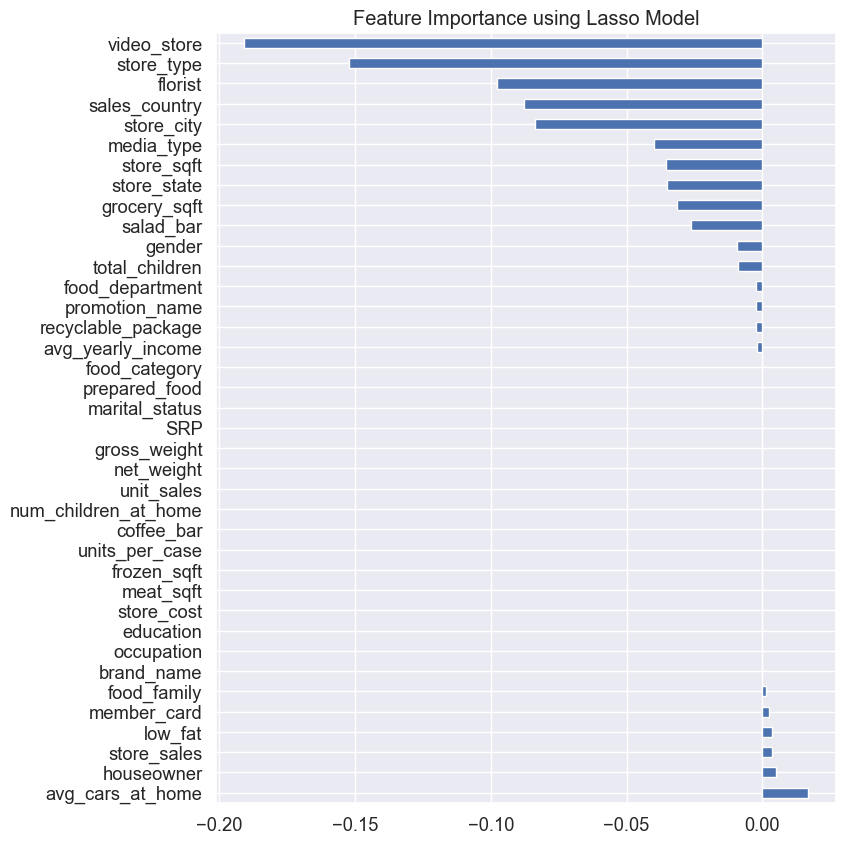

In [42]:
# ------------------------------------------

# Label Encoding
train_set_le = Label_Encoder_(train_set[lst_cat_column])
train_set_le = pd.concat([train_set[train_set.select_dtypes('float64').columns.to_list()], 
                          train_set_le], axis=1)


train_scaled = _standard_scaler(train_set_le)

lasso_cv = LassoCV()

# Fit into train_set after StandardScaler
lasso_cv.fit(train_scaled.drop(columns=config_data['label'],axis=1),
            train_scaled[config_data['label']])

coef = pd.Series(lasso_cv.coef_, index = train_set[train_scaled.drop(columns=config_data['label'],axis=1).columns.to_list()].columns)

imp_coef = coef.sort_values(ascending=False)
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind='barh')
plt.title('Feature Importance using Lasso Model')

Some features get **coef_** or **Beta = 0** on its features after penalized using **L1 Norm Lasso**. <br>
*Shrinkage paramater* or *alpha* used based on Cross Validation

> **'store_cost', 'unit_sales', 'marital_status',
       'num_children_at_home', 'SRP', 'gross_weight', 'net_weight',
       'units_per_case', 'frozen_sqft', 'meat_sqft', 'coffee_bar',
       'food_category', 'food_family', 'education', 'occupation',
       'avg_yearly_income', 'brand_name'**

**Reference:**<br>
[LassoCV](https://medium.com/analytics-vidhya/feature-selection-techniques-2614b3b7efcd)<br>
[Lasso GridSearch](https://towardsdatascience.com/feature-selection-in-machine-learning-using-lasso-regression-7809c7c2771a)


<div style="background-color: yellow;">

### **RANDOM FOREST FEATURE IMPORTANCE**

>**1. Gini Importance** (or mean decrease impurity)

The features for internal nodes on each Decision Tree are selected with some criterion, which for classification tasks can be **gini impurity or infomation gain**, and for regression is **variance reduction**. <br>
We can measure how each feature decrease the impurity of the split (the feature with highest decrease is selected for internal node). <br>
    
For each feature we can collect how on average it decreases the impurity. The average over all trees in the forest is the measure of the feature importance.

>**2. Mean Decrease Accuracy**

is a method of computing the feature importance on permuted out-of-bag (OOB) samples based on mean decrease in the accuracy.<br>

**Reference:**
[Random Forest Feature Selection](https://mljar.com/blog/feature-importance-in-random-forest/)


#### **Random Forest**

In [43]:
rf = RandomForestRegressor()
rf.fit(train_scaled.drop(columns=config_data['label'],axis=1), train_scaled[config_data['label']])

rf.feature_importances_

array([9.53194757e-05, 9.77389595e-05, 1.78741414e-04, 3.05998165e-05,
       6.03441229e-05, 3.74429905e-04, 5.32770691e-05, 1.20709133e-04,
       6.67606992e-05, 1.13938879e-04, 7.80102856e-05, 7.22386107e-05,
       1.20858173e-05, 4.09372789e-05, 1.25187927e-04, 4.08134397e-02,
       3.94591943e-02, 3.96882845e-02, 4.08798308e-02, 1.15219005e-02,
       1.21182582e-02, 3.87235182e-03, 4.58441205e-03, 1.34316600e-02,
       9.60351971e-05, 8.24936968e-05, 2.24440018e-05, 4.16844211e-01,
       1.41498021e-02, 1.15088486e-04, 9.37333472e-05, 3.48386291e-04,
       1.91022505e-04, 1.38881512e-04, 3.23686482e-02, 5.11365039e-02,
       4.06443086e-02, 2.35878789e-01])

Text(0.5, 0, 'Random Forest Feature Importances')

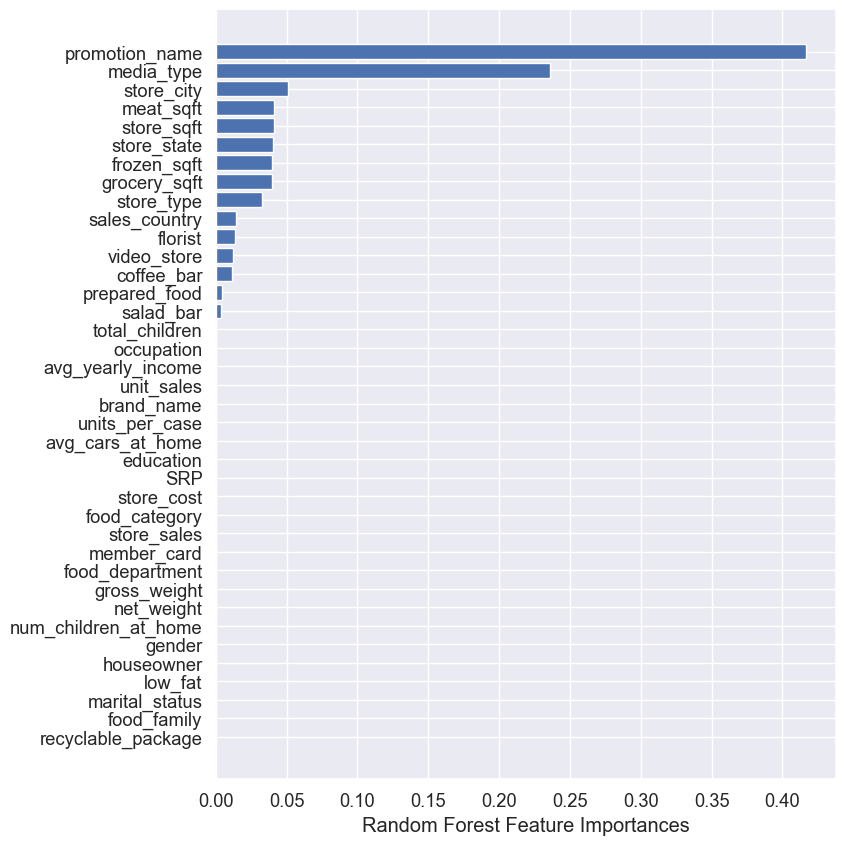

In [44]:
sorted_index = rf.feature_importances_.argsort()
plt.barh(train_scaled.drop(columns=config_data['label'],axis=1).columns[sorted_index], rf.feature_importances_[sorted_index])
plt.xlabel("Random Forest Feature Importances")

#### **Permutation Based Feature Importance**

Text(0.5, 0, 'Permutation Importance')

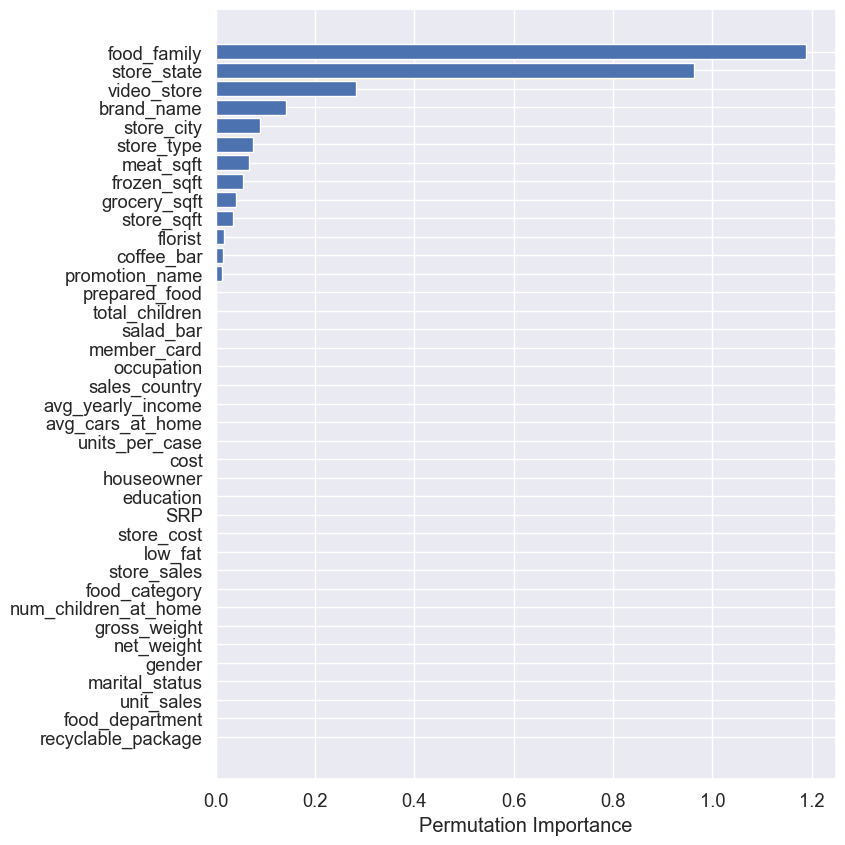

In [45]:
perm_importance = permutation_importance(rf, train_scaled[predictor], train_scaled[config_data['label']])

sorted_index = perm_importance.importances_mean.argsort()
plt.barh(train_scaled.columns[sorted_index], perm_importance.importances_mean[sorted_index])
plt.xlabel("Permutation Importance")

#### **Feature Importance Computed SHAP Values**

The SHAP interpretation can be used (it is model-agnostic) to compute the feature importances from the Random Forest. It is using the Shapley values from game theory to estimate the how does each feature contribute to the prediction.

In [53]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(train_scaled[train_scaled.drop(columns=['cost'],axis=1).columns.to_list()])

shap.summary_plot(shap_values, train_scaled, plot_type="bar")

In the future `np.bool` will be defined as the corresponding NumPy scalar.


AttributeError: module 'numpy' has no attribute 'bool'.
`np.bool` was a deprecated alias for the builtin `bool`. To avoid this error in existing code, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [ ]:
shap.summary_plot(shap_values, train_scaled)

### **RESULT**

Random Forest feature importance based on *Gini Impurity or Information gain* (Classification), *Variance reduction* (Regression) show the average of feature can decrease the **impurity/variance** of the split. <br>
The highest the decrease, the feature will be selected as internal node, and gain more feature importance<br>

These features according to RandomForest and Permutation Based are:
>**'food_family', 'store_state', 'store_type', 'grocery_sqft', 'store_sqft', 
'meat_sqft', 'store_city','frozen_sqft', 'brand_name', 'promotion_name', 'florist', 
'video_store', 'coffee_bar', 'salad_bar', 'prepared_food'**

**Reference:**
[Random Forest Feature Selection](https://mljar.com/blog/feature-importance-in-random-forest/)

In [55]:
## Create new dataset with features drop of lassoCV
train_set_lasso = copy.deepcopy(train_set).drop(columns=['store_cost', 'unit_sales', 'marital_status',
       'num_children_at_home', 'SRP', 'gross_weight', 'net_weight',
       'units_per_case', 'frozen_sqft', 'meat_sqft', 'coffee_bar',
       'food_category', 'food_family', 'education', 'occupation',
       'avg_yearly_income', 'brand_name'], axis=1)

## Create new dataset with features drop of Random Forest
train_set_rf = copy.deepcopy(train_set).drop(columns=['food_family', 'store_state', 'store_type', 'grocery_sqft', 'store_sqft', 
        'meat_sqft', 'store_city','frozen_sqft', 'brand_name', 'promotion_name', 'florist', 
        'video_store', 'coffee_bar', 'salad_bar', 'prepared_food'],axis=1)

In [56]:
train_set_lasso.shape

(42299, 22)

In [57]:
train_set_rf.shape

(42299, 24)

## Compare Between Filtered Method and Embedded Method

In [368]:
print('\033[1m'+ 'Filter method ' + '\033[0m' + f"features that're not in " + '\033[1m' + 'Lasso method' + '\033[0m' + f":\n {np.setdiff1d(train_set_filter.columns, train_set_lasso.columns)}")
print('')
print('='*60)
print('\033[1m'+ 'Filter method ' + '\033[0m' + f"features that're not in " + '\033[1m' + 'Random Forest method' + '\033[0m' + f":\n {np.setdiff1d(train_set_filter.columns, train_set_rf.columns)}")

print('')
print('='*60)
print('\033[1m'+ 'Lasso method ' + '\033[0m' + f"features that're not in " + '\033[1m' + 'Filter method' + '\033[0m' + f":\n {np.setdiff1d(train_set_lasso.columns, train_set_filter.columns)}")
print('')
print('='*60)
print('\033[1m'+ 'Random Forest method ' + '\033[0m' + f"features that're not in " + '\033[1m' + 'Filter method' + '\033[0m' + f":\n {np.setdiff1d(train_set_rf.columns, train_set_filter.columns)}")


Filter method features that're not in Lasso method:
 ['avg_yearly_income' 'coffee_bar' 'net_weight' 'num_children_at_home'
 'occupation' 'store_cost' 'units_per_case']

Filter method features that're not in Random Forest method:
 ['coffee_bar' 'florist' 'prepared_food' 'promotion_name' 'store_city'
 'store_state' 'store_type' 'video_store']

Lasso method features that're not in Filter method:
 ['food_department' 'gender' 'grocery_sqft' 'houseowner' 'low_fat'
 'member_card' 'recyclable_package' 'salad_bar' 'store_sales' 'store_sqft']

Random Forest method features that're not in Filter method:
 ['SRP' 'education' 'food_category' 'food_department' 'gender'
 'gross_weight' 'houseowner' 'low_fat' 'marital_status' 'member_card'
 'recyclable_package' 'store_sales' 'unit_sales']


In [58]:
def _feature_selection(data):
    
    data_filter = data.copy()
    data_filter = data_filter[train_set_filter.columns.to_list()]
    
    data_lasso = data.copy()
    data_lasso = data_lasso[train_set_lasso.columns.to_list()]
    
    data_rf = data.copy()  
    data_rf = data_rf[train_set_rf.columns.to_list()]
        
    return data_filter, data_lasso, data_rf

In [59]:
train_set_filter, train_set_lasso, train_set_rf = _feature_selection(train_set)
valid_set_filter, valid_set_lasso, valid_set_rf = _feature_selection(valid_set)
test_set_filter, test_set_lasso, test_set_rf = _feature_selection(test_set)

## Dump / Save Load Data

In [60]:
def _split_xy(data):
    X = data.drop(columns=[config_data['label']], axis=1)
    y = data[config_data['label']]
    
    return X, y

In [61]:
# Dump data
def _dump_data(data):
    data_filter, data_lasso, data_rf = _feature_selection(data)
    
    X_filter, y_filter = _split_xy(data_filter)
    X_lasso, y_lasso = _split_xy(data_lasso)
    X_rf, y_rf = _split_xy(data_rf)
    
    X_final = {
        "filter" : X_filter,
        "lasso" : X_lasso,
        "rf" : X_rf
    }
    
    y_final = {
        "filter" : y_filter,
        "lasso" : y_lasso,
        "rf" : y_rf
    }
    
    return X_final, y_final

In [62]:
X_train_final, y_train_final = _dump_data(train_set)
X_valid_final , y_valid_final = _dump_data(valid_set)
X_test_final, y_test_final = _dump_data(test_set)

In [63]:
util.pickle_dump(X_train_final, config_data["train_set_eda"][0])
util.pickle_dump(y_train_final, config_data["train_set_eda"][1])

util.pickle_dump(X_valid_final, config_data["valid_set_eda"][0])
util.pickle_dump(y_valid_final, config_data["valid_set_eda"][1])

util.pickle_dump(X_test_final, config_data["test_set_eda"][0])
util.pickle_dump(y_test_final, config_data["test_set_eda"][1])
